In [3]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import scipy.stats as sts

# Описание используемых данных

В первую очередь мы скачали таблицы из датасета по ссылке https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020?select=constructor_results.csv и загрузили их на гитхаб.

В таблице status находится информация о статусе окончания гонки (финишировал ли пилот или по каким-то причинам не смог этого сделать).

В таблице qualifying находится информация о квалификациях: так как каждая квалификация проходит перед гонкой, то в ней указаны id гонки, к которой относится эта квалификация, а также id гонщиков, которые в ней участвовали, места, которые они заняли по итогам квалификации, а также лучшие времена каждого гонщика, показанные в каждом из трех сегментов (q1, q2 и q3).

В таблице drivers находится информация о каждом из гонщиков, а в таблице driver_standings для каждого гонщика указано, какое место он занял в той или иной гонке, а также сколько очков получил.

В таблице constructors находится информация о каждой команде, а в таблице constructor_standings и constructor_results указаны результаты каждой команды в той или иной гонке.

В таблице lap_times для каждого гонщика приведены времена его кругов в той или иной гонке.

В таблице results - информация о результах каждой гонки, а в таблице races - более общая информация о каждой из гонок (в том числе ссылки на сайт википедии про каждую из гонок, которые мы использовали для того, чтобы спарсить данные).

В таблице circuits представлена информация про каждую трассу, на которой проходят или проходили гонки.

Таблица weather - таблица, в которую мы загрузили спарсенные нами данные о погоде во время гонки.

Таблица weather_full - таблица, в которую мы загрузили данные о погоде, которые мы дополнительно спарсили, поэтому эта таблица с погодой не содержит пропусков (Notebook, в котором содержится описание процесса парсинга находится на github).


In [4]:
status = pd.read_csv('https://raw.githubusercontent.com/pavleke/project-formula-1/main/status.csv')
quali = pd.read_csv('https://raw.githubusercontent.com/pavleke/project-formula-1/main/qualifying.csv')
drivers = pd.read_csv('https://raw.githubusercontent.com/pavleke/project-formula-1/main/drivers.csv')
driver_standings = pd.read_csv('https://raw.githubusercontent.com/pavleke/project-formula-1/main/driver_standings.csv')
constructors = pd.read_csv('https://raw.githubusercontent.com/pavleke/project-formula-1/main/constructors.csv')
constructor_standings = pd.read_csv('https://raw.githubusercontent.com/pavleke/project-formula-1/main/constructor_standings.csv')
constructor_results = pd.read_csv('https://raw.githubusercontent.com/pavleke/project-formula-1/main/constructor_results.csv')
lap_times = pd.read_csv('https://raw.githubusercontent.com/pavleke/project-formula-1/main/lap_times.csv')
results = pd.read_csv('https://raw.githubusercontent.com/pavleke/project-formula-1/main/results.csv')
circuits = pd.read_csv('https://raw.githubusercontent.com/pavleke/project-formula-1/main/circuits.csv')
races = pd.read_csv('https://raw.githubusercontent.com/pavleke/project-formula-1/main/races.csv')
weather = pd.read_csv('https://raw.githubusercontent.com/pavleke/project-formula-1/main/weather.csv')
weather_full = pd.read_csv('https://raw.githubusercontent.com/pavleke/project-formula-1/main/weather_full.csv')

# Парсинг информации о погоде в каждой гонке (1)

Мы посчитали необходимым спарсить данные о погоде во время гонок, так как этой информации не было в датасете, который мы выбрали, однако это важный фактор, который вносит хаотичность в гонку. Например, обычно во время дождя происходит большее количество аварий, чем в сухую погоду, а также могут сильнее различаться стратегии, поэтому может быть больше обгонов. Более того, если трасса влажная, на результаты гонки сильнее влияют не характеристики болида, а опыт и талант самого гонщика.

Для того, чтобы спарсить данные о погоде мы использовали статьи про гонки на сайте wikipedia, ссылки на которые находятся в таблице races. Однако в процессе парсинга мы поняли, что информация о погоде там хранится в очень разрозненном виде, поэтому мы классифицировали данные о погоде на несколько категорий: 'wet', 'dry' и 'changing'. В последнюю категорию попали гонки, в описании погоды которых одновременно упоминались маркеры и для дождя, и для сухой погоды. Например, 'rain, later dried out'. 

Кроме того, мы хотели отдельно рассмотреть упоминания о ветренной погоде, но в итоге оказалось, что ветреность упоминалась редко, поэтому этот показатель пришлось не учитывать.

Процесс парсинга и код, который мы использовали, содержится в Notebook parsing_weather_1


Мы добавили спарсенные данные по погоде на гитхаб, они находятся по ссылке:
https://raw.githubusercontent.com/pavleke/project-formula-1/main/weather.csv

В столбце weather_main находится информация о погоде, разделенная на категории, а в столбце weather полная информация о погоде.

В столбце 'wind' находится True, если в описании погоды было слово 'windy', и False, если его не было.

Построим облако слов для столбца weather таблицы weather:

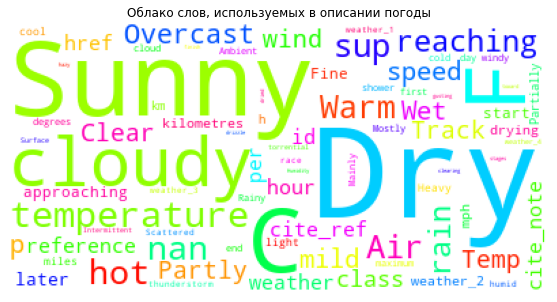

In [5]:
text = ' '.join(i for i in weather['weather'].fillna('nan'))
wordcloud = WordCloud(background_color="white", colormap="hsv", collocations=False).generate(text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Облако слов, используемых в описании погоды')
plt.show()

Как видно на этом графике, самое частоиспользуемое слово - 'Sunny', также часто используются слова 'Cloudy' и 'dry', 'overcast'.

Построим также гистограмму распределения категорий погоды

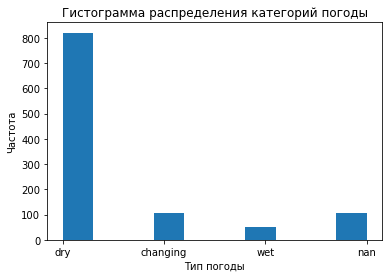

In [6]:
plt.hist(weather['weather_main'].fillna('nan'))
plt.title('Гистограмма распределения категорий погоды')
plt.xlabel('Тип погоды')
plt.ylabel('Частота')
plt.show()

Как видно на гистограмме выше, наиболее распространенная категория погоды - dry

Добавляем информацию о погоде из таблицы weather в таблицу races, используя только столбец weather_main

In [7]:
raceId = pd.DataFrame(races['raceId'])
weather_ = weather.rename({'Unnamed: 0': 'index'}, axis='columns')
weather_.set_index('index')
race_w = raceId.join(weather)
race_w.drop(['Unnamed: 0', 'weather', 'wind'], axis=1, inplace=True)
race_w

,raceId,weather_main
0,1,dry
1,2,changing
2,3,wet
3,4,dry
4,5,dry
...,...,...
1097,1116,NaN
1098,1117,NaN
1099,1118,NaN
1100,1119,NaN


# Обработка различных таблиц и создание общей таблицы с новыми признаками

Для дальнейшего анализа данных перед нами стояла задача собрать в одну таблицу информацию, которая будет релевантна для предсказания итоговых результатов гонки. Для этого мы сформулировали несколько предположений о том, что может влиять на результаты гонки. Ниже будут описаны некоторые из наших предположений и то, какие признаки мы создавали для последующей проверки этих предположений

## Гипотеза-1

### Среднее время круга для каждого гонщика

**Гипотеза**: гонщики, которые в среднем быстрее едут в течение гонки с большей вероятности выиграют эту гонку

Мы подумали, что для того, чтобы сравнивать между собой различных гонщиков, в том числе гонщиков из одной команды, нам нужно получить среднее время круга в каждой гонке для каждого из гонщиков, которые в ней участвовали. Для этого мы использовали таблицу lap_times и после добавляли получившуюся колонку avLapTimeMill в таблицу results. В этом столбце находится среднее время круга каждого из гонщиков в миллисекундах.

In [8]:
pivot_laps = pd.pivot_table(lap_times, values='milliseconds', index=['raceId', 'driverId'], aggfunc=np.mean)
pivot_laps.rename(columns={'milliseconds': 'avLapTimeMill'}, inplace=True)

In [9]:
results_ = results.set_index(['raceId', 'driverId'])
results_av = results_.merge(pivot_laps, how='left', left_index=True, right_index=True)
results_av.reset_index(inplace=True)

In [10]:
results_av.head()

,raceId,driverId,resultId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,avLapTimeMill
0,1,1,7573,1,1,18,\N,D,20,0.0,58,\N,\N,39,13,1:29.020,214.455,2,97563.758621
1,1,2,7563,2,6,9,10,10,10,0.0,58,+7.085,5662869,48,5,1:28.283,216.245,1,97635.672414
2,1,3,7559,3,16,5,6,6,6,3.0,58,+5.722,5661506,48,1,1:27.706,217.668,1,97612.172414
3,1,4,7558,4,7,10,5,5,5,4.0,58,+4.879,5660663,53,9,1:28.712,215.199,1,97597.637931
4,1,5,7572,1,2,12,\N,R,19,0.0,0,\N,\N,\N,\N,\N,\N,4,NaN


In [155]:
results['milliseconds'].replace('\\N', np.nan, inplace=True)

In [156]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25840 entries, 0 to 25839
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   resultId         25840 non-null  int64  
 1   raceId           25840 non-null  int64  
 2   driverId         25840 non-null  int64  
 3   constructorId    25840 non-null  int64  
 4   number           25840 non-null  object 
 5   grid             25840 non-null  int64  
 6   position         25840 non-null  object 
 7   positionText     25840 non-null  object 
 8   positionOrder    25840 non-null  int64  
 9   points           25840 non-null  float64
 10  laps             25840 non-null  int64  
 11  time             25840 non-null  object 
 12  milliseconds     7087 non-null   object 
 13  fastestLap       25840 non-null  object 
 14  rank             25840 non-null  object 
 15  fastestLapTime   25840 non-null  object 
 16  fastestLapSpeed  25840 non-null  object 
 17  statusId    

## Гипотеза-2.1 и гипотеза-2.2

### Количество аварий
### Количество сходов по техническим причинам

**Гипотеза:** существует зависимость между количеством аварий, в которых участвует гонщик и средним количеством обгонов, которые он совершает за гонку.

**Гипотеза:** у команд, для которых характерны частные сходы, меньше шанс на победу

У нас появилась гипотеза, что, например, пилоты с более агрессивным стилем вождения могут как чаще врезаться, так и чаще выигрывать, а кроме того, очевидно, что команды, у которых менее надежные машины будут чаще сходить с дистанции, поэтому реже занимать призовые места. Для того, чтобы проанализировать эти гипотезы, мы решили разделить различные статусы на категории, так как, как видно ниже, изначально в таблице status было слишком много различных категорий

In [11]:
status['status'].unique()

array(['Finished', 'Disqualified', 'Accident', 'Collision', 'Engine',
       'Gearbox', 'Transmission', 'Clutch', 'Hydraulics', 'Electrical',
       '+1 Lap', '+2 Laps', '+3 Laps', '+4 Laps', '+5 Laps', '+6 Laps',
       '+7 Laps', '+8 Laps', '+9 Laps', 'Spun off', 'Radiator',
       'Suspension', 'Brakes', 'Differential', 'Overheating',
       'Mechanical', 'Tyre', 'Driver Seat', 'Puncture', 'Driveshaft',
       'Retired', 'Fuel pressure', 'Front wing', 'Water pressure',
       'Refuelling', 'Wheel', 'Throttle', 'Steering', 'Technical',
       'Electronics', 'Broken wing', 'Heat shield fire', 'Exhaust',
       'Oil leak', '+11 Laps', 'Wheel rim', 'Water leak', 'Fuel pump',
       'Track rod', '+17 Laps', 'Oil pressure', '+42 Laps', '+13 Laps',
       'Withdrew', '+12 Laps', 'Engine fire', 'Engine misfire',
       '+26 Laps', 'Tyre puncture', 'Out of fuel', 'Wheel nut',
       'Not classified', 'Pneumatics', 'Handling', 'Rear wing', 'Fire',
       'Wheel bearing', 'Physical', 'Fuel sys

Мы решили разделить статусы по причинам сходов. Одна из этих категорий - collision (сюда входят аварии и повреждения, которые могут быть получены скорее всего в результате аварий). Эта категория будет нам нужна для того, чтобы в дальнейшем рассмотреть collision rate для каждого гонщика и возможное влияние, которое этот признак оказывает на результаты

В категорию technical включаются причины сходов, которые происходят из-за ненадежности болида, поэтому эту категорию мы будем рассматривать в дальнейшем для того, чтобы проверить гипотезу о влиянии надежности команды на ее результаты

В категорию random включались сходы, которые скорее всего произошли "случайно", то есть, например, из-за того, что на трассе был обломок и кто-то случайно на него наехал или, например, прокол колеса. Такие сходы могли произойти с любым гонщиком, независимо от его команды или стиля вождения, так как обусловлены случайностью

В категорию physical включались сходы по причине физического состояния гонщика, в категорию rules - статусы, которые были обусловлены нарушением каких-либо правил, например, дисквалификация.

В категорию 'out' включались статусы, для которых неизвестно, что стало причиной схода или не участия в гонке. Кроме того, сюда включался такой статус как "fatal accident", потому что мы решили, что неэтично учитывать смертельные аварии в collision rate

В категорию safety включались статусы 'Safety' и 'safety concerns'.

Кроме того, так как среди статусов также есть такие как '+n Laps', мы создали отдельную категорию manylaps в которую включались статусы, в которых n больше 2, потому что очевидно, что в таком случае у гонщика явно случилась какая-то техническая проблема или авария.

In [12]:
collision = ['Collision', 'Broken wing', 'Stalled', 'Eye injury', 'Injury', 'Injured', 'Collision damage', 'Damage', 'Spun off', 'Accident', 'Fatal accident']
technical = ['Engine', 'Gearbox', 'Transmission', 'Clutch', 'Hydraulics', 'Electrical', 
       'Radiator', 'Suspension', 'Brakes', 'Differential', 
       'Overheating','Mechanical', 'Driver Seat', 'Driveshaft',
       'Retired', 'Fuel pressure', 'Front wing', 'Water pressure',
       'Refuelling', 'Wheel', 'Throttle', 'Steering', 'Technical',
       'Electronics', 'Heat shield fire', 'Oil leak', 'Water leak', 'Fuel pump',
       'Track rod', 'Oil pressure', 'Engine fire', 'Engine misfire', 'Out of fuel', 'Wheel nut',
       'Not classified', 'Pneumatics', 'Handling', 'Rear wing', 'Fire',
       'Wheel bearing', 'Fuel system', 'Oil line', 'Fuel rig',
       'Launch control', 'Fuel', 'Power loss', 'Vibrations', 'Drivetrain', 'Ignition',
       'Chassis', 'Battery', 'Halfshaft', 'Crankshaft', 'Alternator', 
       'Safety belt', 'Oil pump', 'Fuel leak', 
       'Injection', 'Distributor', 'Turbo', 'CV joint', 'Water pump',
       'Spark plugs', 'Fuel pipe', 'Oil pipe', 'Axle', 'Water pipe',
       'Magneto', 'Supercharger', 'Power Unit', 'ERS',
       'Brake duct', 'Seat', 'Undertray','Cooling system']
random = ['Tyre', 'Puncture', 'Wheel rim', 'Tyre puncture', 'Debris']
physical = ['Exhaust', 'Physical', 'Driver unwell', 'Illness']
rules = ['Disqualified', '107% Rule', 'Underweight']
out = ['Did not qualify', 'Not restarted', 'Withdrew', 'Excluded', 'Did not prequalify']
safety = ['Safety', 'Safety concerns']
finished = ['Finished'] 
manylaps = ['+3 Laps', '+4 Laps', '+5 Laps', '+6 Laps',
       '+7 Laps', '+8 Laps', '+9 Laps', '+11 Laps', '+17 Laps', '+42 Laps', '+13 Laps',
       '+12 Laps', '+26 Laps', '+10 Laps', '+14 Laps', '+15 Laps',
       '+25 Laps', '+18 Laps', '+22 Laps', '+16 Laps', '+24 Laps',
       '+29 Laps', '+23 Laps', '+21 Laps', '+44 Laps',
       '+30 Laps', '+19 Laps', '+46 Laps', '+20 Laps', '+49 Laps', '+38 Laps']
status.loc[status['status'].isin(collision), 'status_short'] = 'collision'
status.loc[status['status'].isin(technical), 'status_short'] = 'technical'
status.loc[status['status'].isin(random), 'status_short'] = 'random'
status.loc[status['status'].isin(physical), 'status_short'] = 'physical'
status.loc[status['status'].isin(rules), 'status_short'] = 'rules'
status.loc[status['status'].isin(out), 'status_short'] = 'out'
status.loc[status['status'].isin(safety), 'status_short'] = 'safety'
status.loc[status['status'].isin(finished), 'status_short'] = 'finished'
status.loc[status['status'].isin(manylaps), 'status_short'] = 'manylaps'
status.loc[status['status'].isin(['+1 Lap']), 'status_short'] = '+1 Lap'
status.loc[status['status'].isin(['+2 Laps']), 'status_short'] = '+2 Laps'

In [13]:
status.set_index('statusId', inplace=True)
status

,status,status_short
statusId,,
1,Finished,finished
2,Disqualified,rules
3,Accident,collision
4,Collision,collision
5,Engine,technical
...,...,...
137,Damage,collision
138,Debris,random
139,Illness,physical


Объединим нашу таблицу results_av, в которой содержутся results и созданный нами признак avLapTimeMill, и таблицу status

In [14]:
results_st_av = results_av.merge(status, how='left', left_on='statusId', right_index=True)
results_st_av

,raceId,driverId,resultId,constructorId,number,grid,position,positionText,positionOrder,points,...,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,avLapTimeMill,status,status_short
0,1,1,7573,1,1,18,\N,D,20,0.0,...,\N,\N,39,13,1:29.020,214.455,2,97563.758621,Disqualified,rules
1,1,2,7563,2,6,9,10,10,10,0.0,...,+7.085,5662869,48,5,1:28.283,216.245,1,97635.672414,Finished,finished
2,1,3,7559,3,16,5,6,6,6,3.0,...,+5.722,5661506,48,1,1:27.706,217.668,1,97612.172414,Finished,finished
3,1,4,7558,4,7,10,5,5,5,4.0,...,+4.879,5660663,53,9,1:28.712,215.199,1,97597.637931,Finished,finished
4,1,5,7572,1,2,12,\N,R,19,0.0,...,\N,\N,\N,\N,\N,\N,4,NaN,Collision,collision
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25835,1096,848,25838,3,23,19,13,13,13,0.0,...,\N,\N,40,13,1:29.939,211.383,11,92734.105263,+1 Lap,+1 Lap
25836,1096,849,25844,3,6,20,19,19,19,0.0,...,\N,\N,45,14,1:30.309,210.517,130,94472.509091,Collision damage,collision
25837,1096,852,25836,213,22,11,11,11,11,0.0,...,+1:29.371,5355285,40,7,1:29.489,212.446,1,92332.500000,Finished,finished
25838,1096,854,25841,210,47,12,16,16,16,0.0,...,\N,\N,39,12,1:29.833,211.632,11,93069.894737,+1 Lap,+1 Lap


Проанализируем встречаемость различных статусов (как в колонке status, так и в колонке status_short) с помощью облака слов

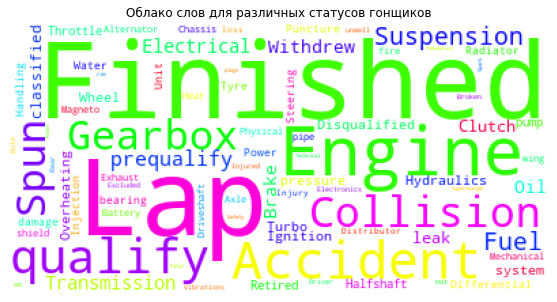

In [15]:
text = ' '.join(i for i in results_st_av['status'])
wordcloud = WordCloud(background_color="white", colormap="hsv", collocations=False).generate(text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Облако слов для различных статусов гонщиков')
plt.show()

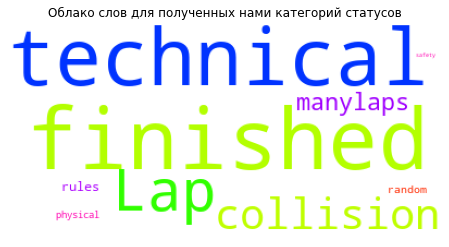

In [16]:
text = ' '.join(i for i in results_st_av.status_short)
wordcloud = WordCloud(background_color="white", colormap="hsv", collocations=False).generate(text)
plt.figure(figsize=(8,4))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Облако слов для полученных нами категорий статусов')
plt.show()

Кроме того, построим гистограмму распределения status_short. Как видно на графиках, наиболее популярные категории - finished и technical

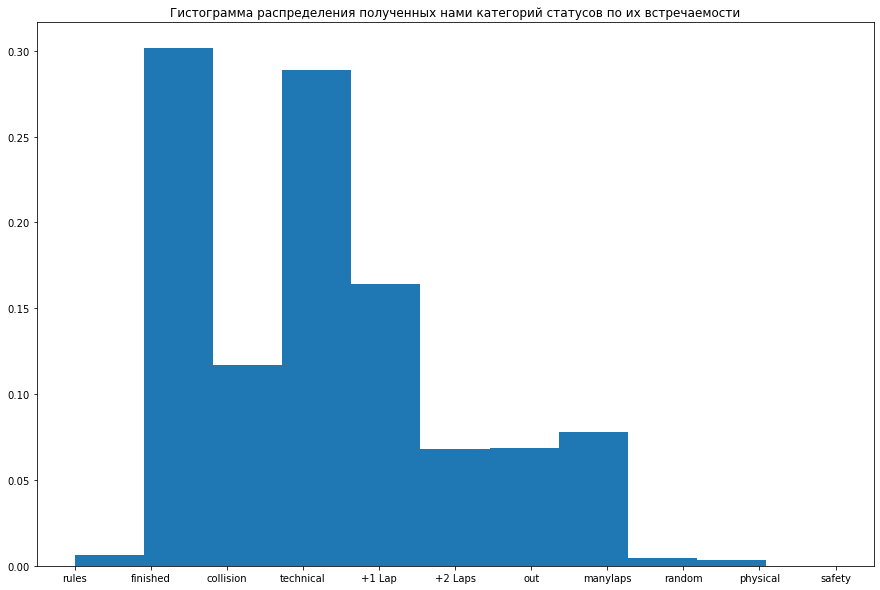

In [17]:
plt.figure(figsize=(15, 10))
plt.hist(results_st_av['status_short'], bins=11, rwidth=2, density=True)
plt.title('Гистограмма распределения полученных нами категорий статусов по их встречаемости')
plt.show()

Кроме того, мы добавили погоду в получившуюся таблицу results_st_av и удалили из нее столбцы, которые скорее всего не понадобятся нам для дальнейшего анализа. Таким образом получилась таблица st_av_w.

In [18]:
results_st_av_w = results_st_av.merge(race_w, how='left', on='raceId')

In [19]:
st_av_w = results_st_av_w.drop(['number', 'positionText', 'position', 'points', 'statusId', 'fastestLap', 'fastestLapSpeed'], axis=1)

Для того, чтобы в дальнейшем проверить нашу гипотезу, нужно создать два новых столбца: во-первых, посчитать процент технических сходов для каждой команды, а, во-вторых, посчитать процент аварий для каждого гонщика

In [20]:
st_av_w

,raceId,driverId,resultId,constructorId,grid,positionOrder,laps,time,milliseconds,rank,fastestLapTime,avLapTimeMill,status,status_short,weather_main
0,1,1,7573,1,18,20,58,\N,\N,13,1:29.020,97563.758621,Disqualified,rules,dry
1,1,2,7563,2,9,10,58,+7.085,5662869,5,1:28.283,97635.672414,Finished,finished,dry
2,1,3,7559,3,5,6,58,+5.722,5661506,1,1:27.706,97612.172414,Finished,finished,dry
3,1,4,7558,4,10,5,58,+4.879,5660663,9,1:28.712,97597.637931,Finished,finished,dry
4,1,5,7572,1,12,19,0,\N,\N,\N,\N,NaN,Collision,collision,dry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25835,1096,848,25838,3,19,13,57,\N,\N,13,1:29.939,92734.105263,+1 Lap,+1 Lap,dry
25836,1096,849,25844,3,20,19,55,\N,\N,14,1:30.309,94472.509091,Collision damage,collision,dry
25837,1096,852,25836,213,11,11,58,+1:29.371,5355285,7,1:29.489,92332.500000,Finished,finished,dry
25838,1096,854,25841,210,12,16,57,\N,\N,12,1:29.833,93069.894737,+1 Lap,+1 Lap,dry


## Гипотеза 3

### Среднее время квалификации для каждой команды

**Гипотеза:** Некоторые гонщики могут выступать стабильно лучше, чем их напарники по команде, поэтому, даже если у этой команды лучшая скорость среди всех остальных, шансы на победу более медленного гонщика ниже, чем шансы на победу у более быстрого гонщика из этой команды

Мы хотели проверить, как в среднем выступают гонщики одной команды в сравнении друг с другом. Для этого мы решили создать столбец avTeamLapTimeMill, в котором находится среднее время круга каждой команды в каждой гонке.

Кроме того, мы решили добавить circuitId в нашу таблицу, так как этот признак понадобится нам в дальнейшем. cir - таблица, с добавленным circuitId, в которую мы будем добавлять признак avTeamQualiTime.

In [21]:
race_cir = races[['raceId', 'circuitId']]
cir = st_av_w.set_index('raceId').join(race_cir.set_index('raceId'), how='left')
cir.reset_index(inplace=True)
cir.set_index(['raceId', 'constructorId'], inplace=True)
cir

driverId  resultId  grid  positionOrder  laps  \
raceId constructorId                                                  
1      1                     1      7573    18             20    58   
       2                     2      7563     9             10    58   
       3                     3      7559     5              6    58   
       4                     4      7558    10              5    58   
       1                     5      7572    12             19     0   
...                        ...       ...   ...            ...   ...   
1096   3                   848     25838    19             13    57   
       3                   849     25844    20             19    55   
       213                 852     25836    11             11    58   
       210                 854     25841    12             16    57   
       51                  855     25837    15             12    57   

                           time milliseconds rank fastestLapTime  \
raceId constructorId                                               
1      1                     \N           \N   13       1:29.020   
       2                 +7.085      5662869    5       1:28.283   
       3                 +5.722      5661506    1       1:27.706   
       4                 +4.879      5660663    9       1:28.712   
       1                     \N           \N   \N             \N   
...                         ...          ...  ...            ...   
1096   3                     \N           \N   13       1:29.939   
       3                     \N           \N   14       1:30.309   
       213            +1:29.371      5355285    7       1:29.489   
       210                   \N           \N   12       1:29.833   
       51                    \N           \N    8       1:29.600   

                      avLapTimeMill            status status_short  \
raceId constructorId                                                 
1      1               97563.758621      Disqualified        rules   
       2               97635.672414          Finished     finished   
       3               97612.172414          Finished     finished   
       4               97597.637931          Finished     finished   
       1                        NaN         Collision    collision   
...                             ...               ...          ...   
1096   3               92734.105263            +1 Lap       +1 Lap   
       3               94472.509091  Collision damage    collision   
       213             92332.500000          Finished     finished   
       210             93069.894737            +1 Lap       +1 Lap   
       51              92718.666667            +1 Lap       +1 Lap   

                     weather_main  circuitId  
raceId constructorId                          
1      1                      dry          1  
       2                      dry          1  
       3                      dry          1  
       4                      dry          1  
       1                      dry          1  
...                           ...        ...  
1096   3                      dry         24  
       3                      dry         24  
       213                    dry         24  
       210                    dry         24  
       51                     dry         24  

[25840 rows x 14 columns]

In [22]:
cir['AvTeamLapTimeMill'] = pd.DataFrame(cir.groupby(['raceId', 'constructorId'])['avLapTimeMill'].mean())

In [23]:
cir_av_st_w = cir.reset_index()
cir_av_st_w.set_index(['raceId', 'driverId'], inplace=True)
cir_av_st_w

constructorId  resultId  grid  positionOrder  laps  \
raceId driverId                                                       
1      1                     1      7573    18             20    58   
       2                     2      7563     9             10    58   
       3                     3      7559     5              6    58   
       4                     4      7558    10              5    58   
       5                     1      7572    12             19     0   
...                        ...       ...   ...            ...   ...   
1096   848                   3     25838    19             13    57   
       849                   3     25844    20             19    55   
       852                 213     25836    11             11    58   
       854                 210     25841    12             16    57   
       855                  51     25837    15             12    57   

                      time milliseconds rank fastestLapTime  avLapTimeMill  \
raceId driverId                                                              
1      1                \N           \N   13       1:29.020   97563.758621   
       2            +7.085      5662869    5       1:28.283   97635.672414   
       3            +5.722      5661506    1       1:27.706   97612.172414   
       4            +4.879      5660663    9       1:28.712   97597.637931   
       5                \N           \N   \N             \N            NaN   
...                    ...          ...  ...            ...            ...   
1096   848              \N           \N   13       1:29.939   92734.105263   
       849              \N           \N   14       1:30.309   94472.509091   
       852       +1:29.371      5355285    7       1:29.489   92332.500000   
       854              \N           \N   12       1:29.833   93069.894737   
       855              \N           \N    8       1:29.600   92718.666667   

                           status status_short weather_main  circuitId  \
raceId driverId                                                          
1      1             Disqualified        rules          dry          1   
       2                 Finished     finished          dry          1   
       3                 Finished     finished          dry          1   
       4                 Finished     finished          dry          1   
       5                Collision    collision          dry          1   
...                           ...          ...          ...        ...   
1096   848                 +1 Lap       +1 Lap          dry         24   
       849       Collision damage    collision          dry         24   
       852               Finished     finished          dry         24   
       854                 +1 Lap       +1 Lap          dry         24   
       855                 +1 Lap       +1 Lap          dry         24   

                 AvTeamLapTimeMill  
raceId driverId                     
1      1              97563.758621  
       2              96398.181661  
       3              94717.203854  
       4              99681.610632  
       5              97563.758621  
...                            ...  
1096   848            93603.307177  
       849            93603.307177  
       852            92538.732456  
       854            93172.157895  
       855            92812.114035  

[25840 rows x 15 columns]

## Гипотеза-4

### Время квалификации для каждого гонщика

**Гипотеза:** скорость гонщика в квалификации влияет на его шансы на победу

Кроме того, скорость каждого гонщика и каждой команды отлично показывает квалификация. При этом иногда результат квалификации не отражает в полной мере скорость пилота - например, он может быть наказан за какое-либо нарушение, поэтому его стартовая позиция (grid) будет отличаться от итоговой позиции в квалификации, или скорость машины позволяла ехать быстрее, но он, например, ошибся в последнем сегменте квалификации. Поэтому мы решили смотреть не только на результаты квалификации, но и на времена гонщиков.

Для того, чтобы в будущем сравнивать скорость различных гонщиков в квалификации, нам нужно было перевести лучшие времена каждого сегмента в квалификации в миллисекунды, так как тип данных, который был присвоен этим колонкам в таблице qualifying не подходил для сравнения. Для этого мы написали следующие функции:

In [24]:
### Функции для перевода времени в миллисекунды

def millisec(x):
    if len(x) == 3:
        min_ = int(x[0]) * 60000
        sec_ = int(x[1]) * 1000
        millis_ = int(x[2])
        y = min_ + sec_ + millis_
    else:
        y = 0
    return y

timing = np.vectorize(millisec)

def separating(qual):
    time = np.array(quali[qual].fillna('no_time'))
    time = time.astype(str)
    time = np.char.replace(time, '.', ':')
    time = np.char.split(time, sep =':')
    time = timing(time)
    return(time)

Используем эти функции на таблице quali

In [25]:
quali['q1Mill'] = separating('q1')
quali['q2Mill'] = separating('q2')
quali['q3Mill'] = separating('q3')
quali

,qualifyId,raceId,driverId,constructorId,number,position,q1,q2,q3,q1Mill,q2Mill,q3Mill
0,1,18,1,1,22,1,1:26.572,1:25.187,1:26.714,86572,85187,86714
1,2,18,9,2,4,2,1:26.103,1:25.315,1:26.869,86103,85315,86869
2,3,18,5,1,23,3,1:25.664,1:25.452,1:27.079,85664,85452,87079
3,4,18,13,6,2,4,1:25.994,1:25.691,1:27.178,85994,85691,87178
4,5,18,2,2,3,5,1:25.960,1:25.518,1:27.236,85960,85518,87236
...,...,...,...,...,...,...,...,...,...,...,...,...
9570,9628,1096,825,210,20,16,1:25.834,\N,\N,85834,0,0
9571,9629,1096,842,213,10,17,1:25.859,\N,\N,85859,0,0
9572,9630,1096,822,51,77,18,1:25.892,\N,\N,85892,0,0
9573,9631,1096,848,3,23,19,1:26.028,\N,\N,86028,0,0


После этого мы удалили ненужные значения и задали новые индексы для того, чтобы потом соединить эту таблицу с таблицей cir_av_st_w

In [26]:
quali_mill = quali.drop(['number', 'q1', 'q2', 'q3', 'qualifyId'], axis=1)
quali_mill.set_index(['raceId', 'driverId'], inplace=True)
quali_mill

constructorId  position  q1Mill  q2Mill  q3Mill
raceId driverId                                                 
18     1                     1         1   86572   85187   86714
       9                     2         2   86103   85315   86869
       5                     1         3   85664   85452   87079
       13                    6         4   85994   85691   87178
       2                     2         5   85960   85518   87236
...                        ...       ...     ...     ...     ...
1096   825                 210        16   85834       0       0
       842                 213        17   85859       0       0
       822                  51        18   85892       0       0
       848                   3        19   86028       0       0
       849                   3        20   86054       0       0

[9575 rows x 5 columns]

Как видно выше, таблица cir_av_st_w - таблица с добавленным avLapTimeMill, к которой мы будем добавлять времена каждого гонщика в квалификации в миллисекундах, которые мы получили выше в таблице quali_mill.

Таблица с добавленными временами в квалификации будет называться cir_q_av_st_w

In [27]:
q = cir_av_st_w.reset_index().merge(quali_mill.reset_index(), how='left', on=['raceId', 'driverId'])

In [28]:
cir_q = q.drop('constructorId_y', axis=1)
cir_q_av_st_w = cir_q.rename(columns={'constructorId_x': 'constructorId', 'position': 'res_q'})
cir_q_av_st_w

,raceId,driverId,constructorId,resultId,grid,positionOrder,laps,time,milliseconds,rank,...,avLapTimeMill,status,status_short,weather_main,circuitId,AvTeamLapTimeMill,res_q,q1Mill,q2Mill,q3Mill
0,1,1,1,7573,18,20,58,\N,\N,13,...,97563.758621,Disqualified,rules,dry,1,97563.758621,15.0,86454.0,0.0,0.0
1,1,2,2,7563,9,10,58,+7.085,5662869,5,...,97635.672414,Finished,finished,dry,1,96398.181661,11.0,85827.0,85504.0,0.0
2,1,3,3,7559,5,6,58,+5.722,5661506,1,...,97612.172414,Finished,finished,dry,1,94717.203854,5.0,85846.0,85123.0,86973.0
3,1,4,4,7558,10,5,58,+4.879,5660663,9,...,97597.637931,Finished,finished,dry,1,99681.610632,12.0,86026.0,85605.0,0.0
4,1,5,1,7572,12,19,0,\N,\N,\N,...,NaN,Collision,collision,dry,1,97563.758621,14.0,86184.0,85726.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25835,1096,848,3,25838,19,13,57,\N,\N,13,...,92734.105263,+1 Lap,+1 Lap,dry,24,93603.307177,19.0,86028.0,0.0,0.0
25836,1096,849,3,25844,20,19,55,\N,\N,14,...,94472.509091,Collision damage,collision,dry,24,93603.307177,20.0,86054.0,0.0,0.0
25837,1096,852,213,25836,11,11,58,+1:29.371,5355285,7,...,92332.500000,Finished,finished,dry,24,92538.732456,12.0,85630.0,85219.0,0.0
25838,1096,854,210,25841,12,16,57,\N,\N,12,...,93069.894737,+1 Lap,+1 Lap,dry,24,93172.157895,13.0,85711.0,85225.0,0.0


## Гипотеза-5

### Дебютная гонка для каждого гонщика

**Гипотеза:** у неопытных гонщиков чаще риск аварий и результаты хуже, чем у более опытных напарников, поэтому их шансы на победу ниже

Так как мы планируем сравнивать гонщиков, мы решили добавить признак, который будет учитывать, является ли эта гонка первой в карьере гонщика. Возможно, при последующем анализе мы заменим этот признак на то, является ли этот сезон первым в карьере гонщика.

Для этого сначала мы создаем таблицу, в которой для каждого гонщика указана его дебютная гонка. (Таблица d)

In [29]:
race = pd.read_csv('https://raw.githubusercontent.com/pavleke/project-formula-1/main/races.csv')
#тут создаем новый id каждой гонки, который зависит от даты проведения гонки
results = pd.read_csv('https://raw.githubusercontent.com/pavleke/project-formula-1/main/results.csv')
new = race.sort_values(by='date')
new['newid'] = np.arange(1, len(new)+1)
#добавляем в результаты новый id гонок, чтобы по нему искать гонщиков
new_result = results.merge(new[['raceId', 'newid']],right_on='raceId', left_on='raceId')
#вытаскиваем из new_results только гонщиков и айди их дебютных гонок (функция min)
new_id = pd.DataFrame(new_result.groupby('driverId')['newid'].min())
ind=new_id['newid']
# вот тут результат: индекс это айди гонщика, в столбцах дебютная гонка
n = new[['newid', 'raceId', 'name', 'date']].set_index('newid')
new_id.reset_index(inplace=True)
new_id.set_index('newid', inplace=True)
drivers_debut = new_id.join(n, how='left')
drivers_debut.reset_index(inplace=True)
drivers_debut.set_index('driverId', inplace=True)
d = drivers_debut[['raceId', 'name']]
d

,raceId,name
driverId,,
579,833,British Grand Prix
589,833,British Grand Prix
619,833,British Grand Prix
627,833,British Grand Prix
640,833,British Grand Prix
...,...,...
852,1052,Bahrain Grand Prix
853,1052,Bahrain Grand Prix
854,1052,Bahrain Grand Prix


Мы сохранили таблицу new на github, так как в дальнейшем она нам понадобится

In [30]:
new.to_csv('new.csv')

Добавим информацию о дебюте гонщика в нашу рабочую таблицу, а также переименуем и удалим некоторые колонки

In [31]:
cir_q_av_st_w_ = cir_q_av_st_w.merge(d, how='left', left_on='driverId', right_index=True)
cir_q_av_st_w_.rename(columns={'raceId_x':'raceId', 'raceId_y':'debut_raceId'}, inplace=True)
cir_q_av_st_w_r = cir_q_av_st_w_.drop('name', axis=1)
cir_q_av_st_w_r

,raceId,driverId,constructorId,resultId,grid,positionOrder,laps,time,milliseconds,rank,...,status,status_short,weather_main,circuitId,AvTeamLapTimeMill,res_q,q1Mill,q2Mill,q3Mill,debut_raceId
0,1,1,1,7573,18,20,58,\N,\N,13,...,Disqualified,rules,dry,1,97563.758621,15.0,86454.0,0.0,0.0,36
1,1,2,2,7563,9,10,58,+7.085,5662869,5,...,Finished,finished,dry,1,96398.181661,11.0,85827.0,85504.0,0.0,158
2,1,3,3,7559,5,6,58,+5.722,5661506,1,...,Finished,finished,dry,1,94717.203854,5.0,85846.0,85123.0,86973.0,53
3,1,4,4,7558,10,5,58,+4.879,5660663,9,...,Finished,finished,dry,1,99681.610632,12.0,86026.0,85605.0,0.0,141
4,1,5,1,7572,12,19,0,\N,\N,\N,...,Collision,collision,dry,1,97563.758621,14.0,86184.0,85726.0,0.0,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25835,1096,848,3,25838,19,13,57,\N,\N,13,...,+1 Lap,+1 Lap,dry,24,93603.307177,19.0,86028.0,0.0,0.0,1010
25836,1096,849,3,25844,20,19,55,\N,\N,14,...,Collision damage,collision,dry,24,93603.307177,20.0,86054.0,0.0,0.0,1031
25837,1096,852,213,25836,11,11,58,+1:29.371,5355285,7,...,Finished,finished,dry,24,92538.732456,12.0,85630.0,85219.0,0.0,1052
25838,1096,854,210,25841,12,16,57,\N,\N,12,...,+1 Lap,+1 Lap,dry,24,93172.157895,13.0,85711.0,85225.0,0.0,1052


Добавим признак is_debut в нашей рабочей таблице, который будет говорить нам True, если данная гонка дебютная для гонщика. Итоговая таблица будет называться cir_q_av_st_w_r

In [32]:
cir_q_av_st_w_r = cir_q_av_st_w_r.astype({'debut_raceId':'int'})
cir_q_av_st_w_r['is_debut'] = (cir_q_av_st_w_r['raceId']==cir_q_av_st_w_r['debut_raceId'])
cir_q_av_st_w_r

,raceId,driverId,constructorId,resultId,grid,positionOrder,laps,time,milliseconds,rank,...,status_short,weather_main,circuitId,AvTeamLapTimeMill,res_q,q1Mill,q2Mill,q3Mill,debut_raceId,is_debut
0,1,1,1,7573,18,20,58,\N,\N,13,...,rules,dry,1,97563.758621,15.0,86454.0,0.0,0.0,36,False
1,1,2,2,7563,9,10,58,+7.085,5662869,5,...,finished,dry,1,96398.181661,11.0,85827.0,85504.0,0.0,158,False
2,1,3,3,7559,5,6,58,+5.722,5661506,1,...,finished,dry,1,94717.203854,5.0,85846.0,85123.0,86973.0,53,False
3,1,4,4,7558,10,5,58,+4.879,5660663,9,...,finished,dry,1,99681.610632,12.0,86026.0,85605.0,0.0,141,False
4,1,5,1,7572,12,19,0,\N,\N,\N,...,collision,dry,1,97563.758621,14.0,86184.0,85726.0,0.0,36,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25835,1096,848,3,25838,19,13,57,\N,\N,13,...,+1 Lap,dry,24,93603.307177,19.0,86028.0,0.0,0.0,1010,False
25836,1096,849,3,25844,20,19,55,\N,\N,14,...,collision,dry,24,93603.307177,20.0,86054.0,0.0,0.0,1031,False
25837,1096,852,213,25836,11,11,58,+1:29.371,5355285,7,...,finished,dry,24,92538.732456,12.0,85630.0,85219.0,0.0,1052,False
25838,1096,854,210,25841,12,16,57,\N,\N,12,...,+1 Lap,dry,24,93172.157895,13.0,85711.0,85225.0,0.0,1052,False


## Гипотеза-6

### Средняя позиция команды на финише в каждом сезоне

**Гипотеза:** результат гонщика в отдельно взятой гонки зависит от того, насколько успешными были результаты его команды в других гонках этого сезона

Так как часто случается так, что некоторые из команд могут построить машину, которая будет существенно быстрее других, мы решили оценивать среднюю позицию команды на финише в каждом сезоне. Эта информация представлена в таблице cir_years_q_av_st_w_r в столбце avPosTeam

In [33]:
years = races[['raceId', 'year']]
cir_years = cir_q_av_st_w_r.merge(years, on='raceId')
cir_y = pd.DataFrame(cir_years.groupby(['year', 'constructorId'])['positionOrder'].mean())
cir_y.rename(columns={'positionOrder': 'avPosTeam'}, inplace=True)
cir_years.set_index(['year', 'constructorId'], inplace=True)
c = cir_years.join(cir_y)
c.reset_index(inplace=True)
cir_years_q_av_st_w_r = c.sort_values(by=['raceId', 'driverId', 'constructorId'])
cir_years_q_av_st_w_r

,year,constructorId,raceId,driverId,resultId,grid,positionOrder,laps,time,milliseconds,...,weather_main,circuitId,AvTeamLapTimeMill,res_q,q1Mill,q2Mill,q3Mill,debut_raceId,is_debut,avPosTeam
19983,2009,1,1,1,7573,18,20,58,\N,\N,...,dry,1,97563.758621,15.0,86454.0,0.0,0.0,36,False,10.411765
20017,2009,2,1,2,7563,9,10,58,+7.085,5662869,...,dry,1,96398.181661,11.0,85827.0,85504.0,0.0,158,False,11.088235
20051,2009,3,1,3,7559,5,6,58,+5.722,5661506,...,dry,1,94717.203854,5.0,85846.0,85123.0,86973.0,53,False,10.970588
20085,2009,4,1,4,7558,10,5,58,+4.879,5660663,...,dry,1,99681.610632,12.0,86026.0,85605.0,0.0,141,False,12.411765
19984,2009,1,1,5,7572,12,19,0,\N,\N,...,dry,1,97563.758621,14.0,86184.0,85726.0,0.0,36,False,10.411765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25486,2022,3,1096,848,25838,19,13,57,\N,\N,...,dry,24,93603.307177,19.0,86028.0,0.0,0.0,1010,False,14.954545
25487,2022,3,1096,849,25844,20,19,55,\N,\N,...,dry,24,93603.307177,20.0,86054.0,0.0,0.0,1031,False,14.954545
25795,2022,213,1096,852,25836,11,11,58,+1:29.371,5355285,...,dry,24,92538.732456,12.0,85630.0,85219.0,0.0,1052,False,13.522727
25751,2022,210,1096,854,25841,12,16,57,\N,\N,...,dry,24,93172.157895,13.0,85711.0,85225.0,0.0,1052,False,14.272727


## Гипотеза-7

### Средняя позиция гонщика на финише в каждом сезоне

**Гипотеза:**  результат гонщика в отдельно взятой гонки зависит от того, насколько успешными были его результаты в других гонках этого сезона

Кроме того, нам также нужно сравнивать и гонщиков внутри одной команды или гонщиков внутри группы команд, которые борются между собой. Для этого будем считать среднюю позицию гонщика на финише в каждый сезон. Информация об этом будет находится в таблице cir_years_d_q_av_st_w_r в столбце avPosDriver

In [34]:
dr = cir_years_q_av_st_w_r
cir_d = pd.DataFrame(dr.groupby(['year', 'driverId'])['positionOrder'].mean())
cir_d.rename(columns={'positionOrder': 'avPosDriver'}, inplace=True)
dr.set_index(['year', 'driverId'], inplace=True)
c = dr.join(cir_d)
c.reset_index(inplace=True)
cir_years_d_q_av_st_w_r = c.sort_values(by=['raceId', 'driverId', 'constructorId'])
cir_years_d_q_av_st_w_r

,year,driverId,constructorId,raceId,resultId,grid,positionOrder,laps,time,milliseconds,...,circuitId,AvTeamLapTimeMill,res_q,q1Mill,q2Mill,q3Mill,debut_raceId,is_debut,avPosTeam,avPosDriver
19983,2009,1,1,1,7573,18,20,58,\N,\N,...,1,97563.758621,15.0,86454.0,0.0,0.0,36,False,10.411765,9.705882
20000,2009,2,2,1,7563,9,10,58,+7.085,5662869,...,1,96398.181661,11.0,85827.0,85504.0,0.0,158,False,11.088235,10.470588
20017,2009,3,3,1,7559,5,6,58,+5.722,5661506,...,1,94717.203854,5.0,85846.0,85123.0,86973.0,53,False,10.970588,8.235294
20034,2009,4,4,1,7558,10,5,58,+4.879,5660663,...,1,99681.610632,12.0,86026.0,85605.0,0.0,141,False,12.411765,9.823529
20051,2009,5,1,1,7572,12,19,0,\N,\N,...,1,97563.758621,14.0,86184.0,85726.0,0.0,36,False,10.411765,11.117647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25750,2022,848,3,1096,25838,19,13,57,\N,\N,...,24,93603.307177,19.0,86028.0,0.0,0.0,1010,False,14.954545,13.904762
25772,2022,849,3,1096,25844,20,19,55,\N,\N,...,24,93603.307177,20.0,86054.0,0.0,0.0,1031,False,14.954545,16.227273
25794,2022,852,213,1096,25836,11,11,58,+1:29.371,5355285,...,24,92538.732456,12.0,85630.0,85219.0,0.0,1052,False,13.522727,14.590909
25816,2022,854,210,1096,25841,12,16,57,\N,\N,...,24,93172.157895,13.0,85711.0,85225.0,0.0,1052,False,14.272727,14.409091


## Гипотеза-8

### Обгонность каждой трассы

**Гипотеза:** на некоторых трассах обгонять сложнее, чем на других, поэтому результаты гонки на этих трассах сильнее зависят от результатов квалификации

Мы хотели проверить, правда ли, что на некоторых трассах обгоны случаются чаще, чем на других. Для этого мы будем сравнивать стартовую позицию каждого гонщика (grid) с его итоговой позицией на финише (positionOrder) на каждой трассе. В результате получим значение overtaking.
 

In [35]:
over = cir_years_d_q_av_st_w_r[['circuitId', 'constructorId', 'grid', 'positionOrder']]
over = over[over.positionOrder != 'None']
over = over[over.positionOrder != '\\N']

over['positionOrder'] = over.positionOrder.astype(int)
over['overtaking'] = abs(over.grid - over.positionOrder)
year_over = over
over = over.groupby('circuitId').mean()
over = over.drop(columns=['grid', 'positionOrder', 'constructorId']) 
over

,overtaking
circuitId,
1,5.135688
2,4.771845
3,3.682500
4,4.773296
5,3.510417
...,...
75,2.550000
76,4.300000
77,3.350000


Построим диаграмму распределения количества "обгонов" (под обгоном мы подразумеваем среднее изменение позиции гонщика относительно его стартовой позиции) по различным трассам

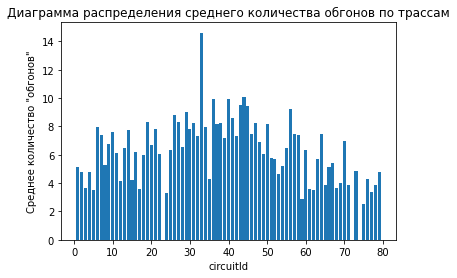

In [36]:
plt.bar(over.index, over.overtaking)
plt.xlabel('circuitId')
plt.ylabel('Среднее количество "обгонов"')
plt.title('Диаграмма распределения среднего количества обгонов по трассам')
plt.show()

Столбец со средней обгонностью каждой трассы называется overCir в общей таблице cir_years_d_q_av_st_q_r_over

In [37]:
cir_years_d_q_av_st_q_r_over = cir_years_q_av_st_w_r.merge(over, how='left', left_on='circuitId', right_index=True)
cir_years_d_q_av_st_q_r_over.rename(columns={'overtaking': 'overCir'}, inplace=True)
cir_years_d_q_av_st_q_r_over

constructorId  raceId  resultId  grid  positionOrder  laps  \
year driverId                                                               
2009 1                     1       1      7573    18             20    58   
     2                     2       1      7563     9             10    58   
     3                     3       1      7559     5              6    58   
     4                     4       1      7558    10              5    58   
     5                     1       1      7572    12             19     0   
...                      ...     ...       ...   ...            ...   ...   
2022 848                   3    1096     25838    19             13    57   
     849                   3    1096     25844    20             19    55   
     852                 213    1096     25836    11             11    58   
     854                 210    1096     25841    12             16    57   
     855                  51    1096     25837    15             12    57   

                    time milliseconds rank fastestLapTime  ...  circuitId  \
year driverId                                              ...              
2009 1                \N           \N   13       1:29.020  ...          1   
     2            +7.085      5662869    5       1:28.283  ...          1   
     3            +5.722      5661506    1       1:27.706  ...          1   
     4            +4.879      5660663    9       1:28.712  ...          1   
     5                \N           \N   \N             \N  ...          1   
...                  ...          ...  ...            ...  ...        ...   
2022 848              \N           \N   13       1:29.939  ...         24   
     849              \N           \N   14       1:30.309  ...         24   
     852       +1:29.371      5355285    7       1:29.489  ...         24   
     854              \N           \N   12       1:29.833  ...         24   
     855              \N           \N    8       1:29.600  ...         24   

              AvTeamLapTimeMill res_q   q1Mill   q2Mill   q3Mill  \
year driverId                                                      
2009 1             97563.758621  15.0  86454.0      0.0      0.0   
     2             96398.181661  11.0  85827.0  85504.0      0.0   
     3             94717.203854   5.0  85846.0  85123.0  86973.0   
     4             99681.610632  12.0  86026.0  85605.0      0.0   
     5             97563.758621  14.0  86184.0  85726.0      0.0   
...                         ...   ...      ...      ...      ...   
2022 848           93603.307177  19.0  86028.0      0.0      0.0   
     849           93603.307177  20.0  86054.0      0.0      0.0   
     852           92538.732456  12.0  85630.0  85219.0      0.0   
     854           93172.157895  13.0  85711.0  85225.0      0.0   
     855           92812.114035  15.0  85594.0  85408.0      0.0   

               debut_raceId  is_debut  avPosTeam   overCir  
year driverId                                               
2009 1                   36     False  10.411765  5.135688  
     2                  158     False  11.088235  5.135688  
     3                   53     False  10.970588  5.135688  
     4                  141     False  12.411765  5.135688  
     5                   36     False  10.411765  5.135688  
...                     ...       ...        ...       ...  
2022 848               1010     False  14.954545  3.324324  
     849               1031     False  14.954545  3.324324  
     852               1052     False  13.522727  3.324324  
     854               1052     False  14.272727  3.324324  
     855               1074     False  13.204545  3.324324  

[25840 rows x 24 columns]

## Гипотеза-9

### В различные сезоны в среднем разное количество обгонов

**Гипотеза:** в разные сезоны могут действовать различные технические регламенты, поэтому в среднем в некоторые сезоны обгонять сложнее, чем в другие

Сделаем операции аналогичные операциям, которые описывались в предыдущем пункте, для оценки среднего количества обгонов по годам, так как в разные периоды времени были различные регламенты, поэтому количество обгонов могло различаться в зависимости от этого.

In [38]:
over = cir_years_d_q_av_st_w_r[['circuitId', 'constructorId', 'grid', 'positionOrder', 'year']]
over = over[over.positionOrder != 'None']
over = over[over.positionOrder != '\\N']

over['positionOrder'] = over.positionOrder.astype(int)
over['overtaking'] = abs(over.grid - over.positionOrder)
year_over = over

year_over = year_over.groupby('year').mean()
year_over = year_over.drop(columns=['grid', 'positionOrder', 'constructorId', 'circuitId']) 
year_over

,overtaking
year,
1950,6.337500
1951,5.061453
1952,7.786047
1953,6.333333
1954,7.056522
...,...
2018,3.871429
2019,3.707143
2020,3.929412


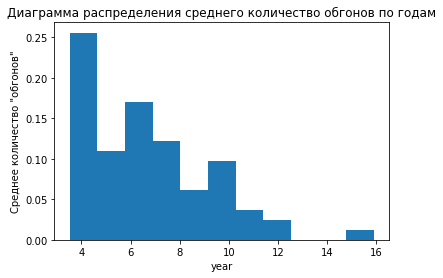

In [39]:
plt.hist(year_over.overtaking, density=True, bins=11)
plt.xlabel('year')
plt.ylabel('Среднее количество "обгонов"')
plt.title('Диаграмма распределения среднего количество обгонов по годам')
plt.show()

In [40]:
over = cir_years_d_q_av_st_w_r[['raceId', 'constructorId', 'grid', 'positionOrder']]
over = over[over.positionOrder != 'None']
over = over[over.positionOrder != '\\N']

over['positionOrder'] = over.positionOrder.astype(int)
over['overtaking'] = abs(over.grid - over.positionOrder)
race_over = over

race_over = race_over.groupby('raceId').mean()
race_over = race_over.drop(columns=['grid', 'positionOrder', 'constructorId']) 
race_over

,overtaking
raceId,
1,6.3
2,3.8
3,4.2
4,3.4
5,2.7
...,...
1092,2.9
1093,5.5
1094,2.6


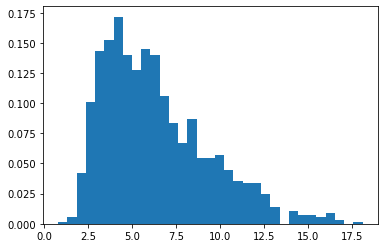

In [41]:
plt.hist(race_over.overtaking, density=True, bins=33)
plt.show()

In [42]:
cir_years_d_q_av_st_q_r_over_ = cir_years_d_q_av_st_q_r_over.reset_index().merge(year_over, how='left', left_on='year', right_index=True)
cir_years_d_q_av_st_q_r_over_.rename(columns={'overtaking': 'overYear'}, inplace=True)
cir_years_d_q_av_st_q_r_over_

,year,driverId,constructorId,raceId,resultId,grid,positionOrder,laps,time,milliseconds,...,AvTeamLapTimeMill,res_q,q1Mill,q2Mill,q3Mill,debut_raceId,is_debut,avPosTeam,overCir,overYear
0,2009,1,1,1,7573,18,20,58,\N,\N,...,97563.758621,15.0,86454.0,0.0,0.0,36,False,10.411765,5.135688,3.858824
1,2009,2,2,1,7563,9,10,58,+7.085,5662869,...,96398.181661,11.0,85827.0,85504.0,0.0,158,False,11.088235,5.135688,3.858824
2,2009,3,3,1,7559,5,6,58,+5.722,5661506,...,94717.203854,5.0,85846.0,85123.0,86973.0,53,False,10.970588,5.135688,3.858824
3,2009,4,4,1,7558,10,5,58,+4.879,5660663,...,99681.610632,12.0,86026.0,85605.0,0.0,141,False,12.411765,5.135688,3.858824
4,2009,5,1,1,7572,12,19,0,\N,\N,...,97563.758621,14.0,86184.0,85726.0,0.0,36,False,10.411765,5.135688,3.858824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25835,2022,848,3,1096,25838,19,13,57,\N,\N,...,93603.307177,19.0,86028.0,0.0,0.0,1010,False,14.954545,3.324324,4.129545
25836,2022,849,3,1096,25844,20,19,55,\N,\N,...,93603.307177,20.0,86054.0,0.0,0.0,1031,False,14.954545,3.324324,4.129545
25837,2022,852,213,1096,25836,11,11,58,+1:29.371,5355285,...,92538.732456,12.0,85630.0,85219.0,0.0,1052,False,13.522727,3.324324,4.129545
25838,2022,854,210,1096,25841,12,16,57,\N,\N,...,93172.157895,13.0,85711.0,85225.0,0.0,1052,False,14.272727,3.324324,4.129545


В дальнейшем мы будем работать с этой таблицей.

# Работа с получившейся таблицей

In [43]:
working = cir_years_d_q_av_st_q_r_over_

Сохраним эту таблицу на github, чтобы в дальнейшем не приходилось запускать остальной код для работы с этой таблицей

In [44]:
working.to_csv('working.csv')

## Устранение пропусков в данных

In [45]:
working = pd.read_csv('https://raw.githubusercontent.com/pavleke/project-formula-1/main/working.csv')
working.replace('\\N', np.nan, inplace=True)
working.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25840 entries, 0 to 25839
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         25840 non-null  int64  
 1   year               25840 non-null  int64  
 2   driverId           25840 non-null  int64  
 3   constructorId      25840 non-null  int64  
 4   raceId             25840 non-null  int64  
 5   resultId           25840 non-null  int64  
 6   grid               25840 non-null  int64  
 7   positionOrder      25840 non-null  int64  
 8   laps               25840 non-null  int64  
 9   time               7088 non-null   object 
 10  milliseconds       7087 non-null   object 
 11  rank               7591 non-null   object 
 12  fastestLapTime     7379 non-null   object 
 13  avLapTimeMill      10146 non-null  float64
 14  status             25840 non-null  object 
 15  status_short       25840 non-null  object 
 16  weather_main       232

как мы видим, основная проблема данной таблицы - результаты квалификации, так как они есть не для всех гонок. Кроме того, правилами обусловлено, что во второй и третий сегмент проходят не все участники квалификации, поэтому у многих гонщиков пропуски значений в столбцах q2 и q3. 

Для начала найдем лучшее время квалификации (во-первых, это позволит убрать пропуски из q2 и q3, а, во-вторых, мы сможем учеть то, что некоторые гонщики могут ошибиться в одном из сегментов и из-за этого стартовать хуже, чем позволяла их скорость). Лучшее время квалификации будем находиться в столбце qBestMill таблицы working.

После этого можно удалить столбцы q1Mill, q2Mill и q3Mill

In [210]:
working = cir_years_d_q_av_st_q_r_over_
working = working.reset_index().drop('rank', axis=1)
working.replace({'q1Mill': 0, 'q2Mill': 0, 'q3Mill': 0}, np.nan, inplace=True)
working['qBestMill'] = working[['q1Mill', 'q2Mill', 'q3Mill']].min(axis=1)
working.drop(['q1Mill', 'q2Mill', 'q3Mill'], axis=1, inplace=True)

In [47]:
working

,index,year,driverId,constructorId,raceId,resultId,grid,positionOrder,laps,time,...,weather_main,circuitId,AvTeamLapTimeMill,res_q,debut_raceId,is_debut,avPosTeam,overCir,overYear,qBestMill
0,0,2009,1,1,1,7573,18,20,58,\N,...,dry,1,97563.758621,15.0,36,False,10.411765,5.135688,3.858824,86454.0
1,1,2009,2,2,1,7563,9,10,58,+7.085,...,dry,1,96398.181661,11.0,158,False,11.088235,5.135688,3.858824,85504.0
2,2,2009,3,3,1,7559,5,6,58,+5.722,...,dry,1,94717.203854,5.0,53,False,10.970588,5.135688,3.858824,85123.0
3,3,2009,4,4,1,7558,10,5,58,+4.879,...,dry,1,99681.610632,12.0,141,False,12.411765,5.135688,3.858824,85605.0
4,4,2009,5,1,1,7572,12,19,0,\N,...,dry,1,97563.758621,14.0,36,False,10.411765,5.135688,3.858824,85726.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25835,25835,2022,848,3,1096,25838,19,13,57,\N,...,dry,24,93603.307177,19.0,1010,False,14.954545,3.324324,4.129545,86028.0
25836,25836,2022,849,3,1096,25844,20,19,55,\N,...,dry,24,93603.307177,20.0,1031,False,14.954545,3.324324,4.129545,86054.0
25837,25837,2022,852,213,1096,25836,11,11,58,+1:29.371,...,dry,24,92538.732456,12.0,1052,False,13.522727,3.324324,4.129545,85219.0
25838,25838,2022,854,210,1096,25841,12,16,57,\N,...,dry,24,93172.157895,13.0,1052,False,14.272727,3.324324,4.129545,85225.0


Однако, так как в столбце qBestMill все равно имеется много пропусков, мы собираемся дополнительно спарсить данные о лучшем круге в квалификации

## Парсинг информации о погоде в каждой гонке (2)

Так как в столбцах с данными о погоде имеется некоторое количество пропусков, мы решили дополнительно спарсить информацию о погоде с другого сайта для тех гонок, в которых пока нет информации по этому признаку. Будем парсить данные с сайта http://f1-data.com/script/menu/race.php. Для каждой гонки на этом сайте существуют отдельные страницы, например: https://f1-data.com/script/db/race/classify.php?race=103
Ссылки на них отличаются только номером гонки, причем номера гонок начинаются с 1 и идут в порядке от самой старой к самой новой.

Подробный процесс парсинга описывается в notebook parsing_weather_2, который лежит на github, а полученные данные о погоде мы совместили с данными, полученные на прошлом этапе парсинга и сохранили в таблицу weather_full

Построим теперь графики, характеризующие встречаемость различных типов погоды для полной таблицы

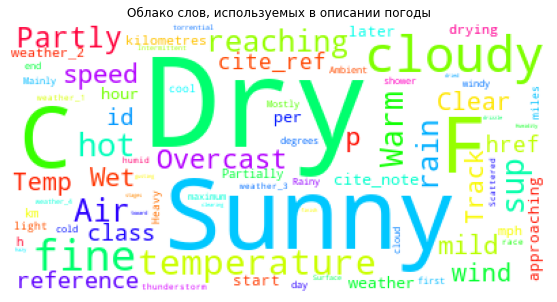

In [48]:
text = ' '.join(i for i in weather_full['weather'].fillna('nan'))
wordcloud = WordCloud(background_color="white", colormap="hsv", collocations=False).generate(text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Облако слов, используемых в описании погоды')
plt.show()

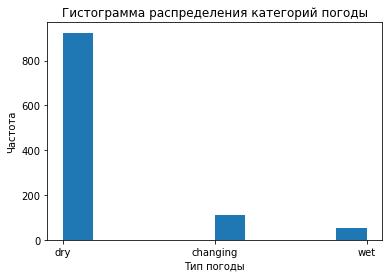

In [49]:
plt.hist(weather_full['weather_main'].fillna('nan'))
plt.title('Гистограмма распределения категорий погоды')
plt.xlabel('Тип погоды')
plt.ylabel('Частота')
plt.show()

Как видно на графиках выше, самая популярная категория погоды - dry, а самая редкая - wet

### Парсинг времени каждого гонщика в квалификациях

Парсинг данной инфорации представлен в файле parsing_qualifying, результаты были сохранены на гитхаб в таблицу quali_full.csv

Добавим все в таблицу working

In [208]:
quali_full = pd.read_csv('https://raw.githubusercontent.com/pavleke/project-formula-1/main/quali_full.csv')
quali_full

,Unnamed: 0,raceNewid,driverNumber,resultId,raceId,driverId,driverTime,driverTimeMill
0,0,786,22,1.0,18.0,1.0,1:26.572,86572.0
1,1,786,3,2.0,18.0,2.0,1:25.960,85960.0
2,2,786,7,3.0,18.0,3.0,1:26.295,86295.0
3,3,786,5,4.0,18.0,4.0,1:26.907,86907.0
4,4,786,23,5.0,18.0,5.0,1:25.664,85664.0
...,...,...,...,...,...,...,...,...
26125,26125,1084,4,NaN,NaN,NaN,1:28.394,88394.0
26126,26126,1084,22,NaN,NaN,NaN,1:28.429,88429.0
26127,26127,1084,18,NaN,NaN,NaN,1:28.476,88476.0
26128,26128,1084,81,NaN,NaN,NaN,1:28.484,88484.0


In [211]:
working.set_index(['raceId', 'driverId'], inplace=True)
quali_full.set_index(['raceId', 'driverId'], inplace=True)
quali_full.drop('resultId', axis=1, inplace=True)
working_full = working.merge(quali_full, right_index=True, left_index=True)

In [212]:
working_full.reset_index(inplace=True)
working_full.drop(['driverTime', 'qBestMill', 'time', 'avLapTimeMill', 'res_q'], axis=1, inplace=True)
working_full

,raceId,driverId,index,year,constructorId,resultId,grid,positionOrder,laps,milliseconds,...,AvTeamLapTimeMill,debut_raceId,is_debut,avPosTeam,overCir,overYear,Unnamed: 0,raceNewid,driverNumber,driverTimeMill
0,1,1,0,2009,1,7573,18,20,58,\N,...,97563.758621,36,False,10.411765,5.135688,3.858824,7572,804,1,86454.0
1,1,2,1,2009,2,7563,9,10,58,5662869,...,96398.181661,158,False,11.088235,5.135688,3.858824,7562,804,6,85827.0
2,1,3,2,2009,3,7559,5,6,58,5661506,...,94717.203854,53,False,10.970588,5.135688,3.858824,7558,804,16,85846.0
3,1,4,3,2009,4,7558,10,5,58,5660663,...,99681.610632,141,False,12.411765,5.135688,3.858824,7557,804,7,86026.0
4,1,5,4,2009,1,7572,12,19,0,\N,...,97563.758621,36,False,10.411765,5.135688,3.858824,7571,804,2,86184.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26092,1096,848,25835,2022,3,25838,19,13,57,\N,...,93603.307177,1010,False,14.954545,3.324324,4.129545,25894,1079,23,86028.0
26093,1096,849,25836,2022,3,25844,20,19,55,\N,...,93603.307177,1031,False,14.954545,3.324324,4.129545,25900,1079,6,86054.0
26094,1096,852,25837,2022,213,25836,11,11,58,5355285,...,92538.732456,1052,False,13.522727,3.324324,4.129545,25892,1079,22,85630.0
26095,1096,854,25838,2022,210,25841,12,16,57,\N,...,93172.157895,1052,False,14.272727,3.324324,4.129545,25897,1079,47,85711.0


# Проверка гипотез

## Гипотеза 1

Мы решили пренебречь этой информацией, так как данных по каждому кругу в каждой гонке недостаточно для того, чтобы делать какие-либо показательные выводы

## Гипотезы 2.1 и 2.2

Для проверки этих гипотез сначала нужно получить новые показатели - collision_rate для каждого гонщика и technical_rate для каждой команды

Посчитаем сначала долю гонок для каждого гонщика, которые закончились аварией. Это нужно для того, чтобы оценить насколько стиль вождения каждого гонщика приводит к авариям.

In [213]:
grouped_col = working_full.groupby(['driverId', 'status_short']).size().unstack(fill_value=0)['collision']
collision_rate = pd.DataFrame(grouped_col/working_full.groupby('driverId').count()['status_short'])
collision_rate.rename(columns={0: 'collision_rate'}, inplace=True)
working_full = working_full.merge(collision_rate, left_on='driverId', right_index=True)
working_full

,raceId,driverId,index,year,constructorId,resultId,grid,positionOrder,laps,milliseconds,...,debut_raceId,is_debut,avPosTeam,overCir,overYear,Unnamed: 0,raceNewid,driverNumber,driverTimeMill,collision_rate
0,1,1,0,2009,1,7573,18,20,58,\N,...,36,False,10.411765,5.135688,3.858824,7572,804,1,86454.0,0.045161
20,2,1,20,2009,1,7580,12,7,31,4312825,...,36,False,10.411765,4.771845,3.858824,7579,805,1,95280.0,0.045161
40,3,1,40,2009,1,7599,9,6,56,7135351,...,36,False,10.411765,3.584795,3.858824,7598,806,1,95776.0,0.045161
60,4,1,60,2009,1,7617,5,4,57,5530278,...,36,False,10.411765,3.682500,3.858824,7616,807,1,92851.0,0.045161
80,5,1,80,2009,1,7642,14,9,65,\N,...,36,False,10.411765,4.773296,3.858824,7641,808,1,80991.0,0.045161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26036,1093,855,25779,2022,51,25777,18,12,56,6207851,...,1074,False,13.204545,3.990291,4.129545,25833,1076,24,96656.0,0.090909
26056,1094,855,25799,2022,51,25798,12,13,70,\N,...,1074,False,13.204545,7.306950,4.129545,25854,1077,24,80283.0,0.090909
26076,1095,855,25819,2022,51,25817,13,12,71,5943369,...,1074,False,13.204545,5.998885,4.129545,25873,1078,24,75197.0,0.090909
26096,1096,855,25839,2022,51,25837,15,12,57,\N,...,1074,False,13.204545,3.324324,4.129545,25893,1079,24,85594.0,0.090909


Также посчитаем среднее количество обгонов за гонку для каждого гонщика, для того, чтобы потом посмотреть на корреляцию между этим показателем и collision_rate. Для дальнейшей проверки гипотезы создадим отдельный датафрейм df_for_testing_2_1, в котором находятся два исследуемых признака

In [220]:
working_full['overtakings'] = working_full['grid'] - working_full['positionOrder']
mean_overtakings = pd.DataFrame(working_full.groupby(['driverId'])['overtakings'].mean())
df_for_testing_2_1 = mean_overtakings.merge(collision_rate, left_index=True, right_index=True)

Посчитаем долю технических сходов для каждой команды. Так как каждый год во время зимней паузы команды дорабатывают свою машину или разрабатывают новую, если регламент был изменен, мы решили, что логичнее считать процент технических сходов для каждой команды ежегодно.

In [137]:
grouped_tech = working_full.groupby(['constructorId', 'year', 'status_short']).size().unstack(fill_value=0)['technical']
technical_rate = pd.DataFrame(grouped_tech/working_full.groupby(['constructorId', 'year']).count()['status_short'])
technical_rate.rename(columns={0: 'technical_rate'}, inplace=True)
working_full = working_full.merge(technical_rate, left_on=['constructorId', 'year'], right_index=True)
working_full

,raceId,driverId,index,year,constructorId,resultId,grid,positionOrder,laps,milliseconds,...,is_debut,avPosTeam,overCir,overYear,Unnamed: 0,raceNewid,driverNumber,driverTimeMill,collision_rate,technical_rate
0,1,1,0,2009,1,7573,18,20,58,\N,...,False,10.411765,5.135688,3.858824,7572,804,1,86454.0,0.045161,0.058824
20,2,1,20,2009,1,7580,12,7,31,4312825,...,False,10.411765,4.771845,3.858824,7579,805,1,95280.0,0.045161,0.058824
40,3,1,40,2009,1,7599,9,6,56,7135351,...,False,10.411765,3.584795,3.858824,7598,806,1,95776.0,0.045161,0.058824
60,4,1,60,2009,1,7617,5,4,57,5530278,...,False,10.411765,3.682500,3.858824,7616,807,1,92851.0,0.045161,0.058824
80,5,1,80,2009,1,7642,14,9,65,\N,...,False,10.411765,4.773296,3.858824,7641,808,1,80991.0,0.045161,0.058824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25576,1069,854,25319,2021,210,25301,16,16,54,\N,...,False,17.386364,3.990291,3.520455,25357,1052,47,96499.0,0.068182,0.068182
25596,1070,854,25339,2021,210,25324,14,19,0,\N,...,False,17.386364,7.306950,3.520455,25380,1053,47,78858.0,0.068182,0.068182
25616,1071,854,25359,2021,210,25343,18,18,69,\N,...,False,17.386364,5.998885,3.520455,25399,1054,47,70329.0,0.068182,0.068182
25636,1072,854,25379,2021,210,25385,19,20,8,\N,...,False,17.386364,3.350000,3.520455,25441,1056,47,89464.0,0.068182,0.068182


### Проверка гипотезы 2.1

**$H_0:$** corr(mean_overtakings, collision_rate) $= 0$

**$H_1:$** corr(mean_overtakings, collision_rate) $\neq 0$

In [221]:
corr = np.corrcoef(df_for_testing_2_1['overtakings'], df_for_testing_2_1['collision_rate'])[0][1]
corr

0.06227284104312352

In [225]:
t_obs = corr*np.sqrt(len(df_for_testing_2_1['overtakings']) - 2)/(np.sqrt(1 - corr**2))
t_real = sts.t.ppf(0.95, len(df_for_testing_2_1['overtakings'])-2)
print('Наблюдаемое t = ' + str(t_obs))
print('Реальное t на уровне значимости 0.05 = ' + str(t_real))
if (t_obs < -t_real) or (t_obs > t_real):
    print('Гипотеза об отсутствии корреляции между итоговым результатом гонки и временем в квалификации отвергается в пользу альтернативной на уровне значимости 0.05')
else:
    print('Нет оснований для отвержения гипотезы H0, то есть корреляция не является значимой')

Наблюдаемое t = 1.822287554352381
Реальное t на уровне значимости 0.05 = 1.6466419451812693
Гипотеза об отсутствии корреляции между итоговым результатом гонки и временем в квалификации отвергается в пользу альтернативной на уровне значимости 0.05


Заметим, что корреляция между данными признаками достаточно мала, но все же положительна, то есть между средним количеством обгонов для каждого гонщика и его процентом аварий существует положительная зависимость. Возможно, корреляция достаточно мала из-за того, что количество обгонов, совершенное гонщиком нейтрализуется его проигрышами позиций из-за аварий. 

**Проверим гипотезу о корреляции между процентом аварий гонщика и изменением его позиций по модулю (вместо признака overtakings будем изучать признак abs_overtakings).**

Эта гипотеза не такая интересная с точки зрения того, положительно ли влияет агрессивный стиль вождения гонщика на его пощиции на финише, однако она интересная с точки зрения того, действительно ли количество аварий, в которых участвует гонщик и количество борьбы, в которой он участвует, имеет положительную зависимость.

In [232]:
working_full['abs_overtakings'] = abs(working_full['grid'] - working_full['positionOrder'])
mean_overtakings = pd.DataFrame(working_full.groupby(['driverId'])['abs_overtakings'].mean())
df_for_testing_2_2 = mean_overtakings.merge(collision_rate, left_index=True, right_index=True)

In [242]:
corr_abs = np.corrcoef(df_for_testing_2_2['abs_overtakings'], df_for_testing_2_2['collision_rate'])[0][1]
corr_abs

-0.15921210652618312

Проверим теперь значимость этой корреляции

In [243]:
t_obs = corr_abs*np.sqrt(len(df_for_testing_2_2['abs_overtakings']) - 2)/(np.sqrt(1 - corr_abs**2))
t_real = sts.t.ppf(0.95, len(df_for_testing_2_2['abs_overtakings'])-2)
print('Наблюдаемое t = ' + str(t_obs))
print('Реальное t на уровне значимости 0.05 = ' + str(t_real))
if (t_obs < -t_real) or (t_obs > t_real):
    print('Гипотеза об отсутствии корреляции между итоговым результатом гонки и временем в квалификации отвергается в пользу альтернативной на уровне значимости 0.05')
else:
    print('Нет оснований для отвержения гипотезы H0, то есть корреляция не является значимой')

Наблюдаемое t = -4.710054422137039
Реальное t на уровне значимости 0.05 = 1.6466419451812693
Гипотеза об отсутствии корреляции между итоговым результатом гонки и временем в квалификации отвергается в пользу альтернативной на уровне значимости 0.05


Посмотрев на полученные результаты, мы подумали, что, возможно, корреляция получается отрицательной из-за того, что 

In [236]:
working_full['overtakings_only_positive'] = working_full['overtakings']
working_full.loc[working_full['overtakings'] < 0, 'overtakings_only_positive'] = 0

In [238]:
mean_overtakings_pos = pd.DataFrame(working_full.groupby(['driverId'])['overtakings_only_positive'].mean())
df_for_testing_2_3 = mean_overtakings_pos.merge(collision_rate, left_index=True, right_index=True)

In [240]:
corr_pos = np.corrcoef(df_for_testing_2_3['overtakings_only_positive'], df_for_testing_2_3['collision_rate'])[0][1]
corr_pos

-0.0903768479656233

(array([  2.,   2.,   6.,   8.,  11.,  17.,   9.,   8.,  11.,  13.,  13.,
          7.,  10.,  21.,  33.,  31.,  53., 101., 150., 126.,  79.,  60.,
         41.,  22.,   6.,   8.,   3.,   2.,   1.,   1.]),
 array([-38.83333333, -36.77222222, -34.71111111, -32.65      ,
        -30.58888889, -28.52777778, -26.46666667, -24.40555556,
        -22.34444444, -20.28333333, -18.22222222, -16.16111111,
        -14.1       , -12.03888889,  -9.97777778,  -7.91666667,
         -5.85555556,  -3.79444444,  -1.73333333,   0.32777778,
          2.38888889,   4.45      ,   6.51111111,   8.57222222,
         10.63333333,  12.69444444,  14.75555556,  16.81666667,
         18.87777778,  20.93888889,  23.        ]),
 <BarContainer object of 30 artists>)

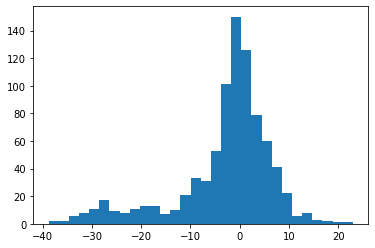

In [248]:
plt.hist(df_for_testing_2_1['overtakings'], bins=30)

(array([ 33.,  95., 163., 175., 110.,  56.,  45.,  39.,  17.,  24.,  18.,
         13.,  11.,  19.,  12.,   8.,   8.,   5.,   2.,   2.]),
 array([ 0.        ,  1.94166667,  3.88333333,  5.825     ,  7.76666667,
         9.70833333, 11.65      , 13.59166667, 15.53333333, 17.475     ,
        19.41666667, 21.35833333, 23.3       , 25.24166667, 27.18333333,
        29.125     , 31.06666667, 33.00833333, 34.95      , 36.89166667,
        38.83333333]),
 <BarContainer object of 20 artists>)

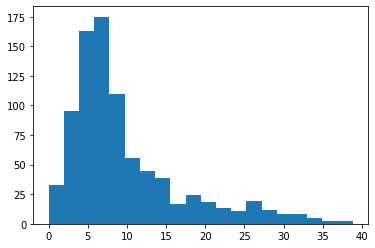

In [249]:
plt.hist(df_for_testing_2_2['abs_overtakings'], bins=20)

(array([192., 171., 164., 108.,  82.,  43.,  41.,  17.,  10.,   7.,   4.,
          4.,   5.,   3.,   2.,   0.,   1.,   0.,   0.,   1.]),
 array([ 0.  ,  1.15,  2.3 ,  3.45,  4.6 ,  5.75,  6.9 ,  8.05,  9.2 ,
        10.35, 11.5 , 12.65, 13.8 , 14.95, 16.1 , 17.25, 18.4 , 19.55,
        20.7 , 21.85, 23.  ]),
 <BarContainer object of 20 artists>)

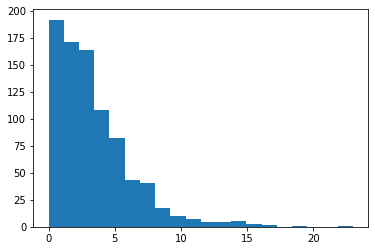

In [253]:
plt.hist(df_for_testing_2_3['overtakings_only_positive'], bins=20)

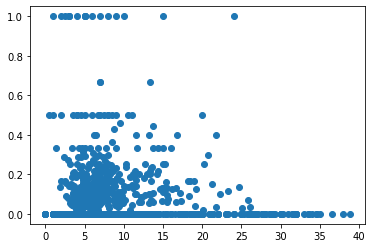

In [250]:
plt.scatter(df_for_testing_2_2['abs_overtakings'], df_for_testing_2_2['collision_rate'])

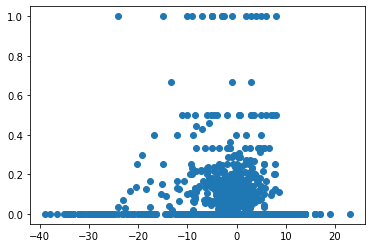

In [251]:
plt.scatter(df_for_testing_2_1['overtakings'], df_for_testing_2_1['collision_rate'])

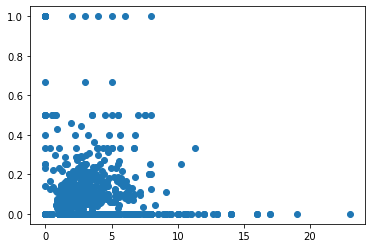

In [252]:
plt.scatter(df_for_testing_2_3['overtakings_only_positive'], df_for_testing_2_3['collision_rate'])

In [246]:
working_full.loc[working_full['status_short'] == 'collision']

,raceId,driverId,index,year,constructorId,resultId,grid,positionOrder,laps,milliseconds,...,overCir,overYear,Unnamed: 0,raceNewid,driverNumber,driverTimeMill,collision_rate,overtakings,abs_overtakings,overtakings_only_positive
220,12,1,220,2009,1,7792,12,19,0,\N,...,6.449918,3.858824,7791,815,1,105767.0,0.045161,-7,7,0
240,13,1,240,2009,1,7805,1,12,52,\N,...,7.775056,3.858824,7804,816,1,83375.0,0.045161,-11,11,0
468,24,1,468,2008,1,147,1,19,19,\N,...,7.388340,4.048913,146,792,22,76909.0,0.045161,-18,18,0
1038,51,1,1038,2007,1,717,1,19,30,\N,...,3.584795,3.700535,716,784,2,95798.0,0.045161,-18,18,0
8205,350,1,8205,2010,1,20657,5,23,0,\N,...,7.775056,4.346491,20718,834,2,82830.0,0.045161,-18,18,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25596,1070,854,25339,2021,210,25324,14,19,0,\N,...,7.306950,3.520455,25380,1053,47,78858.0,0.068182,-5,5,0
25636,1072,854,25379,2021,210,25385,19,20,8,\N,...,3.350000,3.520455,25441,1056,47,89464.0,0.068182,-1,1,0
25795,1080,854,25538,2022,210,25544,15,19,24,\N,...,7.934113,4.129545,25600,1064,47,73469.0,0.068182,-4,4,0
25856,1083,855,25599,2022,51,25604,9,19,0,\N,...,6.787249,4.129545,25660,1067,24,100791.0,0.090909,-10,10,0


## Гипотеза 3

Данная гипотеза была изменена в процессе нашей работы, так как мы поняли, что данных по каждому кругу в каждой гонке недостаточно, поэтому и данных для среднего времени круга для каждой команды недостаточно. Кроме того, оценивать среднее время круга в гонке неразумно, если мы собираемся предсказывать результаты гонки по итогам квалификации. Поэтому мы решили, что можно измерять среднюю скорость команды на основе средней скорости команды в квалификации. Это позволит понять, когда у кого-либо в квалификации произошел форс-мажор, поэтому в гонке он сможет существенно улучшить свое место. Так, например, может случиться такое, что гонщик на потенциально быстрейшей машине врезался в квалификации или, например, у него сломалась машина или произошло что-то странное и поэтому он не прошел во второй или третий сегмент квалификации. Однако в гонке он может быть настолько быстр, что быстро обгонит всех остальных пилотов. (Возможно, можно просто создать столбец, в который мы будем писать True если это Макс Ферстаппен или Льюис Хэмилтон, но мы не будем этого делать)

Создадим столбец avTeamQualiMill на основе столбца driverTimeMill со временем круга в квалификации

In [171]:
working_full.set_index(['raceId', 'constructorId'], inplace=True)

In [172]:
working_full['avTeamQualiMill'] = pd.DataFrame(working_full.groupby(['raceId', 'constructorId'])['driverTimeMill'].mean())

In [173]:
working_full.reset_index(inplace=True)

In [174]:
working_full

,raceId,constructorId,driverId,index,year,resultId,grid,positionOrder,laps,milliseconds,...,overYear,Unnamed: 0,raceNewid,driverNumber,driverTimeMill,collision_rate,technical_rate,avTimeByQuali,driverTimeMillNormed,avTeamQualiMill
0,1,1,1,0,2009,7573,18,20,58,\N,...,3.858824,7572,804,1,86454.0,0.045161,0.058824,86041.75,1.004791,86319.000000
1,1,1,5,4,2009,7572,12,19,0,\N,...,3.858824,7571,804,2,86184.0,0.080357,0.058824,86041.75,1.001653,86319.000000
2,1,2,2,1,2009,7563,9,10,58,5662869,...,3.858824,7562,804,6,85827.0,0.092391,0.117647,86041.75,0.997504,85874.500000
3,1,2,9,8,2009,7567,4,14,55,\N,...,3.858824,7566,804,5,85922.0,0.040404,0.117647,86041.75,0.998608,85874.500000
4,1,3,3,2,2009,7559,5,6,58,5661506,...,3.858824,7558,804,16,85846.0,0.067961,0.088235,86041.75,0.997725,85960.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26092,837,51,642,20719,1950,20121,1,4,35,10291000,...,6.337500,20301,5,8,277000.0,0.046512,0.375000,162500.00,1.704615,278333.333333
26093,837,51,786,20728,1950,20119,3,2,35,10060000,...,6.337500,20299,5,12,281000.0,0.100000,0.375000,162500.00,1.729231,278333.333333
26094,837,6,633,20718,1950,20123,4,6,33,\N,...,6.337500,20303,5,2,287000.0,0.075000,0.470588,162500.00,1.766154,287500.000000
26095,837,6,647,20720,1950,20122,7,5,34,\N,...,6.337500,20302,5,4,288000.0,0.068182,0.470588,162500.00,1.772308,287500.000000


### Проверка гипотезы 3

Сформулируем гипотезу:

Н0: корреляция между разницей между временами напарников по команде и разницей их итоговых позиций на финише равна 0

Н1: корреляция не равна нулю

Для этого найдем среднюю позиции каждой команды в каждой гонке (не путать это со столбцом avPosTeam, в котором мы посчитали среднюю позицию каждой команды в каждом сезоне) и найдем разницу между этим и результатом гонщика.

In [175]:
working_full.set_index(['raceId', 'constructorId'], inplace=True)
working_full['avPosTeamRace'] = pd.DataFrame(working_full.groupby(['raceId', 'constructorId'])['positionOrder'].mean())

In [176]:
working_full.reset_index(inplace=True)

In [177]:
working_full['diffPosOrder'] = working_full['avPosTeamRace'] - working_full['positionOrder']

In [188]:
working_full['driverTimeMill'].replace(0, np.nan, inplace=True)

Посчитаем разницу между временем гонщика в квалификации и средним временем команды в квалификации, это будет в столбике diffQualiMill

In [189]:
working_full['diffQualiMill'] = (working_full['avTeamQualiMill'] - working_full['driverTimeMill'])/working_full['driverTimeMill']

In [190]:
working_full['diffQualiMill'].fillna(0, inplace=True)

In [191]:
working_full['diffPosOrder'].fillna(0, inplace=True)

In [181]:
working_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26097 entries, 0 to 26096
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   raceId                26097 non-null  int64  
 1   constructorId         26097 non-null  int64  
 2   driverId              26097 non-null  int64  
 3   index                 26097 non-null  int64  
 4   year                  26097 non-null  int64  
 5   resultId              26097 non-null  int64  
 6   grid                  26097 non-null  int64  
 7   positionOrder         26097 non-null  int64  
 8   laps                  26097 non-null  int64  
 9   milliseconds          26097 non-null  object 
 10  fastestLapTime        26097 non-null  object 
 11  status                26097 non-null  object 
 12  status_short          26097 non-null  object 
 13  weather_main          23410 non-null  object 
 14  circuitId             26097 non-null  int64  
 15  AvTeamLapTimeMill  

Посчитаем корреляцию между этими двумя величинами (diffPosOrder и diffQualiMill)

In [202]:
corr = sts.pearsonr(working_full['diffPosOrder'], working_full['diffQualiMill'])[0]

In [203]:
corr

-0.037919132847828906

Теперь проверим значимости коэффициента корреляции с помощью t-теста. Заметим, что из-за большого размера выборки можно сказать, что распределение стремится к нормальному. В данном случае H0 заключается в отсутствии корреляции между переменными (corr=0), соответственно альтернативная гипотеза заключается в том, что corr != 0

In [204]:
t_obs = corr*np.sqrt(len(working_full['diffQualiMill']) - 2)/(np.sqrt(1 - corr**2))
t_real = sts.t.ppf(0.95, len(working_full['diffQualiMill'])-2)
print('Наблюдаемое t = ' + str(t_obs))
print('Реальное t на уровне значимости 0.05 = ' + str(t_real))
if (t_obs < -t_real) or (t_obs > t_real):
    print('Гипотеза об отсутствии корреляции между итоговым результатом гонки и временем в квалификации отвергается в пользу альтернативной на уровне значимости 0.05')
else:
    print('Нет оснований для отвержения гипотезы H0')

Наблюдаемое t = -6.129845096683097
Реальное t на уровне значимости 0.05 = 1.644912022183254
Гипотеза об отсутствии корреляции между итоговым результатом гонки и временем в квалификации отвергается в пользу альтернативной на уровне значимости 0.05


**Вывод**: мы посчитали корреляцию и осознали, что, на самом деле, нам нельзя судить о значимости корреляции между оцениваемыми переменными, так как одна из них является ранговой, а вторая нет. Поэтому, несмотря на то, что мы видим, что существует некоторая отрицательная зависимость между временем квалификации и результатом гонки, лучше посчитать корреляцию между стартовой позицией (grid) и итоговым результатом (positionOrder), так как обе эти переменные являются ранговыми. В одном из следующих разделов мы посчитаем эту корреляцию

## Гипотеза 4

Cкорость гонщика в квалификации влияет на его шансы на победу

### Проверка гипотезы 4

In [138]:
working_full['driverTimeMill'].fillna(0, inplace=True)

In [139]:
grouped_quali_time = pd.DataFrame(working_full.groupby('raceId').mean()['driverTimeMill'])
grouped_quali_time.rename(columns={'driverTimeMill': 'avTimeByQuali'}, inplace=True)
grouped_quali_time

,avTimeByQuali
raceId,
1,86041.75
2,95295.75
3,96447.30
4,93402.20
5,81080.40
...,...
1092,90949.40
1093,96553.25
1094,80024.20


In [140]:
working_full = working_full.merge(grouped_quali_time, left_on='raceId', right_index=True)

In [142]:
working_full['driverTimeMillNormed'] = working_full['driverTimeMill']/working_full['avTimeByQuali']

In [145]:
working_full['driverTimeMillNormed'].fillna(0, inplace=True)

In [150]:
working_full

,raceId,driverId,index,year,constructorId,resultId,grid,positionOrder,laps,milliseconds,...,overCir,overYear,Unnamed: 0,raceNewid,driverNumber,driverTimeMill,collision_rate,technical_rate,avTimeByQuali,driverTimeMillNormed
0,1,1,0,2009,1,7573,18,20,58,\N,...,5.135688,3.858824,7572,804,1,86454.0,0.045161,0.058824,86041.75,1.004791
4,1,5,4,2009,1,7572,12,19,0,\N,...,5.135688,3.858824,7571,804,2,86184.0,0.080357,0.058824,86041.75,1.001653
1,1,2,1,2009,2,7563,9,10,58,5662869,...,5.135688,3.858824,7562,804,6,85827.0,0.092391,0.117647,86041.75,0.997504
8,1,9,8,2009,2,7567,4,14,55,\N,...,5.135688,3.858824,7566,804,5,85922.0,0.040404,0.117647,86041.75,0.998608
2,1,3,2,2009,3,7559,5,6,58,5661506,...,5.135688,3.858824,7558,804,16,85846.0,0.067961,0.088235,86041.75,0.997725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20970,837,642,20719,1950,51,20121,1,4,35,10291000,...,6.449918,6.337500,20301,5,8,277000.0,0.046512,0.375000,162500.00,1.704615
20979,837,786,20728,1950,51,20119,3,2,35,10060000,...,6.449918,6.337500,20299,5,12,281000.0,0.100000,0.375000,162500.00,1.729231
20969,837,633,20718,1950,6,20123,4,6,33,\N,...,6.449918,6.337500,20303,5,2,287000.0,0.075000,0.470588,162500.00,1.766154
20971,837,647,20720,1950,6,20122,7,5,34,\N,...,6.449918,6.337500,20302,5,4,288000.0,0.068182,0.470588,162500.00,1.772308


Посчитаем корреляцию между итоговым результатом гонки (позицией каждого гонщика на финише) и его временем в квалификации

In [146]:
corr = np.corrcoef(working_full['positionOrder'], working_full['driverTimeMillNormed'])[0][1]

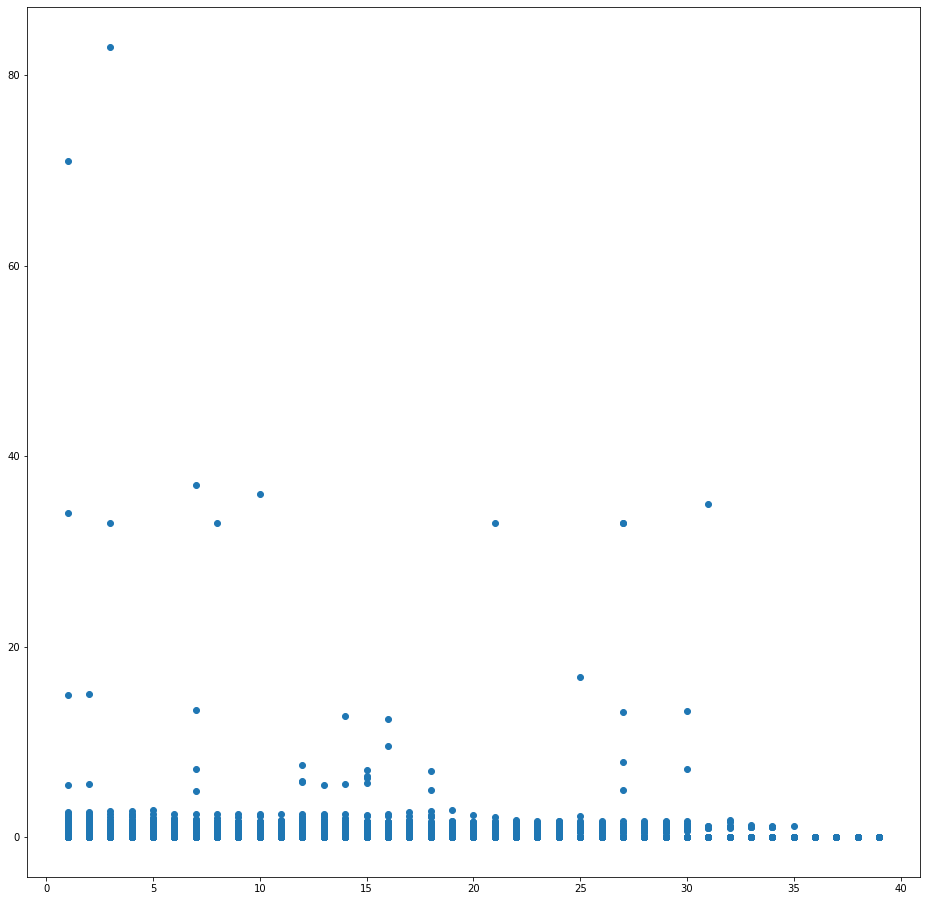

In [149]:
plt.figure(figsize=(16,16))
plt.scatter(working_full['positionOrder'], working_full['driverTimeMillNormed'])

Теперь проверим значимости коэффициента корреляции с помощью t-теста. Заметим, что из-за большого размера выборки можно сказать, что распределение стремится к нормальному. В данном случае H0 заключается в отсутствии корреляции между переменными (corr=0), соответственно альтернативная гипотеза заключается в том, что corr != 0

In [110]:
t_obs = corr*np.sqrt(len(working_full['driverTimeMill']) - 2)/(np.sqrt(1 - corr**2))
t_real = sts.t.ppf(0.95, len(working_full['driverTimeMill'])-2)
print('Наблюдаемое t = ' + str(t_obs))
print('Реальное t на уровне значимости 0.05 = ' + str(t_real))
if (t_obs < -t_real) or (t_obs > t_real):
    print('Гипотеза об отсутствии корреляции между итоговым результатом гонки и временем в квалификации отвергается в пользу альтернативной на уровне значимости 0.05')
else:
    print('Нет оснований для отвержения гипотезы H0')

Наблюдаемое t = -15.275730037992146
Реальное t на уровне значимости 0.05 = 1.644912022183254
Гипотеза об отсутствии корреляции между итоговым результатом гонки и временем в квалификации отвергается в пользу альтернативной на уровне значимости 0.05


# Цели на машинное обучение

### В рамках нашего проекта мы хотим использовать машинное обучение для достижения двух целей:

1. Предсказание топ-3 результатов каждой гонки на основе информации о результатах квалификации и сформированных нами признаков

2. Определение вероятности победы для каждого гонщика

In [63]:
working = pd.read_csv('https://raw.githubusercontent.com/pavleke/project-formula-1/main/working.csv')

In [64]:
working.loc[working['year']==2022]

,Unnamed: 0,year,driverId,constructorId,raceId,resultId,grid,positionOrder,laps,time,...,AvTeamLapTimeMill,res_q,q1Mill,q2Mill,q3Mill,debut_raceId,is_debut,avPosTeam,overCir,overYear
25400,25400,2022,1,131,1074,25408,5,3,57,+9.675,...,102877.666667,5.0,92285.0,91048.0,91238.0,36,False,5.522727,3.682500,4.129545
25401,25401,2022,4,214,1074,25414,8,9,57,+22.390,...,103061.236842,8.0,92346.0,91621.0,92195.0,141,False,9.863636,3.682500,4.129545
25402,25402,2022,807,117,1074,25422,17,17,57,+1:03.829,...,103656.754386,17.0,92777.0,0.0,0.0,337,False,11.886364,3.682500,4.129545
25403,25403,2022,815,9,1074,25423,4,18,56,\N,...,103308.420304,4.0,92311.0,91008.0,90921.0,841,False,4.454545,3.682500,4.129545
25404,25404,2022,817,1,1074,25419,18,14,57,+54.975,...,103670.859649,18.0,92945.0,0.0,0.0,849,False,10.636364,3.682500,4.129545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25835,25835,2022,848,3,1096,25838,19,13,57,\N,...,93603.307177,19.0,86028.0,0.0,0.0,1010,False,14.954545,3.324324,4.129545
25836,25836,2022,849,3,1096,25844,20,19,55,\N,...,93603.307177,20.0,86054.0,0.0,0.0,1031,False,14.954545,3.324324,4.129545
25837,25837,2022,852,213,1096,25836,11,11,58,+1:29.371,...,92538.732456,12.0,85630.0,85219.0,0.0,1052,False,13.522727,3.324324,4.129545
25838,25838,2022,854,210,1096,25841,12,16,57,\N,...,93172.157895,13.0,85711.0,85225.0,0.0,1052,False,14.272727,3.324324,4.129545


In [157]:
working_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26097 entries, 0 to 20978
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   raceId                26097 non-null  int64  
 1   driverId              26097 non-null  int64  
 2   index                 26097 non-null  int64  
 3   year                  26097 non-null  int64  
 4   constructorId         26097 non-null  int64  
 5   resultId              26097 non-null  int64  
 6   grid                  26097 non-null  int64  
 7   positionOrder         26097 non-null  int64  
 8   laps                  26097 non-null  int64  
 9   milliseconds          26097 non-null  object 
 10  fastestLapTime        26097 non-null  object 
 11  status                26097 non-null  object 
 12  status_short          26097 non-null  object 
 13  weather_main          23410 non-null  object 
 14  circuitId             26097 non-null  int64  
 15  AvTeamLapTimeMill  

## Гипотеза про связь grid и positionOrder

In [160]:
corr = np.corrcoef(working_full['positionOrder'], working_full['grid'])[0][1]
corr

0.15193839429237882

In [170]:
t_obs = corr*np.sqrt(len(working_full['grid']) - 2)/(np.sqrt(1 - corr**2))
t_real = sts.t.ppf(0.95, len(working_full['grid'])-2)
print('Наблюдаемое t = ' + str(t_obs))
print('Реальное t на уровне значимости 0.05 = ' + str(t_real))
if (t_obs < -t_real) or (t_obs > t_real):
    print('Гипотеза об отсутствии корреляции между итоговым результатом гонки и временем в квалификации отвергается в пользу альтернативной на уровне значимости 0.05')
else:
    print('Нет оснований для отвержения гипотезы H0')

Наблюдаемое t = 24.832351971224238
Реальное t на уровне значимости 0.05 = 1.644912022183254
Гипотеза об отсутствии корреляции между итоговым результатом гонки и временем в квалификации отвергается в пользу альтернативной на уровне значимости 0.05
